In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [26]:
fileprefix = "full_o" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [27]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
extract_max_trials = 40
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    timeFirstAction = []
    timeFirstClick = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    rewardsWithheld = []
    reached_max_trials = False
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    firstLevelAns = {}
    strategyImprove = ""
    difficult = ""
    clickStratsValid = True
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                    continue
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                timeFirstAction.append(trial['trialdata']['actionTimes'][0])
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                try:
                    timeFirstClick.append(trial['trialdata']['queries']['click']['state']['time'][0])
                except:
                    timeFirstClick.append(None)
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']
                expectedScores.append(planQuality)
        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
            
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    
    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if "excludeReason" in participant:
        excludedReason = participant["excludeReason"]
    else:
        excludedReason = None
    
    clickStratsValid = excludedReason is None
    
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "excludedReason": excludedReason,
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "timeFirstAction" : timeFirstAction,
        "timeFirstClick" : timeFirstClick,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable,
        "clickStratsValid": clickStratsValid
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

6139d8c791c9b4805690b33e
60f724fd8ec131e82a00b129
5db050bee16e28001752bc92
612cb8236aa1cef2599e6f59
61375098ac2bf903b0364ec3
64803fe717b0a137be421ae1
613758e7a80409ba7f5affb6
61702a081098614cd58391a8
5fc0c7b73605db59cfd30666
6156e9372fa5f9c6cc31eb63
615ad127d286180356188f84
5b2c0994f1ca3c000190196a
5dc3ebd9d0b86f2c8dc18c30
5b52fb6cb3c9400001f23bb5
612537b2bd6b4a38f4e7f63a
60b0f62eb8e276ae78fd6180
5f04de147fee46163c1b40e1
61644a9055a7fdced6a7aa9c
60ed6ef739959cc28d143526
61649f39b3155900189833cb
5e9027110aacc7320bd9a84b
605996d037bce4fb5488a375
6152c05b866a2622004014a5
60fb1b68ff87fb94e0e721f6
611d0d396f50f8e800c6b740
60f814d5348f2f80c0e60c3a
611d317b41f033a2bc24ca51
614769c080877000c8de42ee
5f1c5d097881234e5034cb12
60be90f1912d5331e734e92c
615b5ddab1de3c02771daed5
6153703d974b2bf60bccf6e2
60eb29c01cbb5ca4a8a5ea2e
615a2c11b1a80d0b33a58bf9
64699c39810132db3b4250b1
6112d782efc9ce932196cc7e
6166a03f5063db088c458b73
5f9ac9de923dca223848cf19
606c6e9f7e86c0264ab3d7d8
611cf4676874122c771e0c70


In [28]:
# Compiling all data into trial data

exclude_parts = ["61693a88caa235cc1209b3ca"]

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5", "clickStratsValid", "timeFirstAction", "timeFirstClick"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'clickStratsValid':
        return [part["clickStratsValid"]] * len(part['trialScores'])
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    else:
        return part[field]

for part in part_stats_dicts:
    
    if part["excludedReason"] and part["excludedReason"] != "invalidClickStrats":
        print(part['condition'], part['workerId'], part["excludedReason"], len(part['trialScores']))
        continue
    if len(part['trialScores']) not in [40]:
        
        print(part['condition'], part['workerId'], "MDP Data Incomplete", len(part['trialScores']))
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    if part["workerId"] in exclude_parts:
        print(part['condition'], part['workerId'], "Excluding participant")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


1 612cb8236aa1cef2599e6f59 quizfail 0
0 61375098ac2bf903b0364ec3 dropout 0
1 615ad127d286180356188f84 dropout 0
0 60b0f62eb8e276ae78fd6180 quizfail 0
0 60ed6ef739959cc28d143526 exceededTime 40
1 611d0d396f50f8e800c6b740 quizfail 0
0 60be90f1912d5331e734e92c quizfail 0
0 64699c39810132db3b4250b1 quizfail 0
0 6112d782efc9ce932196cc7e dropout 0
0 606c6e9f7e86c0264ab3d7d8 alreadyparticipated 40
1 6483247637d20bcecd41963b dataincomplete 28
1 615b37de9f81596034aeb896 quizfail 0
0 611d2f96b140246f8f2d18bc dataincomplete 15
1 603ea08e7dc2aaf9eb6d9225 dropout 0
1 60dc31374fc70253e7a2d9e9 dataincomplete 32
0 63174af7d57182f9bf90c094 alreadyparticipated 40
0 610d4b020c0ec927cbd29bb4 quizfail 0
1 61693a88caa235cc1209b3ca dataincomplete 40
0 5e0df69e6f6d3e5342ba6d24 dataincomplete 32
0 615349801b7897c0c37bd359 noeffort 40
0 6152f8ecefde7f8298316ee6 quizfail 0
0 605de3af48d7a575adb95b09 alreadyparticipated 40
1 61688ab804063e6cec34cec6 dataincomplete 20
0 5e4e6e53f4bdd82b601f2e9a dataincomplete 26
0

In [29]:
all_trials_df_backup = all_trials_df.copy()

In [30]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            9.00            0.00          0       0.000000             1  \
1           58.00            0.00          0       0.000000             2   
2           20.00            0.00          0       0.000000             3   
3          -14.00            0.00          0       0.000000             4   
4          -42.00            0.00          0       0.000000             5   
...           ...             ...        ...            ...           ...   
8395        46.70           46.70          2       5.000000            36   
8396        14.55           22.55          3       3.333333            37   
8397        46.40           59.40          4       3.750000            38   
8398        55.70           35.70          2       5.000000            39   
8399        74.85           81.85          1       5.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             1  6139d8c791c9b4805690b33e         0         0         0  \
1             1  6139d8c791c9b4805690b33e         0         0         0   
2             1  6139d8c791c9b4805690b33e         0         0         0   
3             1  6139d8c791c9b4805690b33e         0         0         0   
4             1  6139d8c791c9b4805690b33e         0         0         0   
...         ...                       ...       ...       ...       ...   
8395          1  6401e7719c0cc074162322fc         0         0         0   
8396          1  6401e7719c0cc074162322fc         0         0         0   
8397          1  6401e7719c0cc074162322fc         0         0         0   
8398          1  6401e7719c0cc074162322fc         0         0         0   
8399          1  6401e7719c0cc074162322fc         0         0         0   

      clicksL4  clicksL5  clickStratsValid  timeFirstAction  timeFirstClick  
0            0         0              True             4692             NaN  
1            0         0              True             5214             NaN  
2            0         0              True             3907             NaN  
3            0         0              True             2621             NaN  
4            0         0              True             2776             NaN  
...        ...       ...               ...              ...             ...  
8395         0         2              True             8761          2082.0  
8396         0         2              True            11593          2008.0  
8397         0         3              True            15365          1896.0  
8398         0         2              True             8517          1596.0  
8399         0         1              True             5294          1631.0  

[8400 rows x 15 columns]

In [31]:
sorted(list(all_trials_df.workerId.unique()))

['558841bdfdf99b4020ba0902',
 '56f81ffe1b99b8000636b9c8',
 '5ad5b79ce704600001542ec7',
 '5b2c0994f1ca3c000190196a',
 '5b51e5f2fde5fe000162df3a',
 '5b52fb6cb3c9400001f23bb5',
 '5be9784e18a71d0001317761',
 '5c28d36b6fbaed00010847a8',
 '5cf91e3f1756e60017a30568',
 '5d77a3cabdd252000197e86e',
 '5db050bee16e28001752bc92',
 '5dc3ebd9d0b86f2c8dc18c30',
 '5de60f418f5cd559c333199c',
 '5e289268cebc01066df1db2b',
 '5e593e1b5f129b0168be047a',
 '5e8e38da572c650e2ede51c9',
 '5e9027110aacc7320bd9a84b',
 '5e930e7f1baf78649acfc7c4',
 '5e9822781c48fa016d3ea705',
 '5e98ebda7eda83135fb21c30',
 '5e9efe26ffd5fe04e506d7f3',
 '5ea62c8bba2bb363b85cbbd2',
 '5ea7caacf5d2171a87ce9dea',
 '5ea96886ef7ece0604eee527',
 '5eb12f8510e0ce205e7b25c7',
 '5ec95924a88e734583d2d2b8',
 '5ee10f63a397864aba0bcc09',
 '5ef9b70e432ef80119d3d829',
 '5f04de147fee46163c1b40e1',
 '5f0f4e2e850b230eb3e7bb95',
 '5f1c5d097881234e5034cb12',
 '5f227527667206737350c7c3',
 '5f5f5c0ab70c7b000ad0d7b7',
 '5f9ac9de923dca223848cf19',
 '5fa0091ec747

## Analyzing Inferred Strategies

In [54]:
# Reset dataframe to remove strategies

all_trials_df = all_trials_df_backup.copy()

In [55]:
# Defining paths

# CM inferred strategies
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

mis_inferred = inferred_path + "/misaligned_exp_exp1/strategies.pkl"
control_inferred = inferred_path + "/misaligned_control_exp1/strategies.pkl"

# Output files for strategies
mis_file = results_path + "/mouselab-mdp-final-misaligned.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"

click_depths_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"
click_depths_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"

base_mis_cost_struc = [-0.25, 0.35, 0.95, 1.55, 2.15]
base_control_cost_struc = [1.4] * 5

adj_mis_cost_struc = [1.75, 2.35, 2.95, 3.55, 9.65]
adj_control_cost_struc = [6.4] * 5

problematic_strategies = [19, 20, 25, 35, 38, 52, 68, 77, 81, 83]


use_adj_costs = False

if use_adj_costs:
    mis_cost_struc = adj_mis_cost_struc
    control_cost_struc = adj_control_cost_struc
else:
    mis_cost_struc = base_mis_cost_struc
    control_cost_struc = base_control_cost_struc

# Simulation constant cost for each node
simulation_cost = 1.0
num_simulations = 200000

mis_df_rows = []
control_df_rows = []

In [56]:
# Reading csv files

with open(mis_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        mis_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [57]:
# Reading inferred strategies

with open(mis_inferred, 'rb') as f:
    mis_strategies = pickle.load(f)
    
with open(control_inferred, 'rb') as f:
    control_strategies = pickle.load(f)

In [58]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'condition']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [59]:
mis_strategies["6139d8c791c9b4805690b33e"]

[30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30]

In [60]:
for workerId, stratList in mis_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [61]:
# Reading strategy scores without costs and click depths of strategies

with open(strategy_scores_mis_path, 'rb') as file:
    strategy_scores_mis_raw = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control_raw = pickle.load(file)
    
with open(click_depths_mis_path, 'rb') as file:
    click_depths_mis = pickle.load(file)
    
with open(click_depths_control_path, 'rb') as file:
    click_depths_control = pickle.load(file)


In [62]:
# Correct the scores of all strategies based on the clicks made at each depth
def correct_strategy_scores(score_dict, strat_d_clicks, d_costs, num_sims, sim_cost):
    scores_copy = score_dict.copy()
    for s in scores_copy.keys():
        d_clicks = strat_d_clicks[s]
        s_score = score_dict[s]
        new_s_score = adjust_strat_score(s_score, num_sims, sim_cost, d_clicks, d_costs)
        scores_copy[s] = new_s_score

    return scores_copy

# Adjust the strategy score based on the cost structure at each depth
def adjust_strat_score(score, num_sims, simulation_cost, depth_click_list, depth_cost_list):
    total_points = score * num_sims
    costs_already_deducted = sum(
        [num_sims * simulation_cost * d_clicks for d_clicks in depth_click_list])
    costs_to_be_deducted = sum(
        [d_cost * num_sims * d_clicks for (d_cost, d_clicks) in zip(depth_cost_list, depth_click_list)])
    #print(costs_already_deducted, costs_to_be_deducted)
    updated_score = (total_points + costs_already_deducted - costs_to_be_deducted) / num_simulations
    return updated_score

In [63]:

# Adjust strategy scores based on the cost of the environment and sort
strategy_scores_mis = correct_strategy_scores(strategy_scores_mis_raw, click_depths_mis, mis_cost_struc, num_simulations, simulation_cost)
strategy_scores_mis = dict(sorted(strategy_scores_mis.items(), key=lambda item: item[1], reverse=True))
strategy_scores_mis = {k + 1: v for (k, v) in strategy_scores_mis.items() if k + 1 not in problematic_strategies}


strategy_scores_control = correct_strategy_scores(strategy_scores_control_raw, click_depths_control, control_cost_struc, num_simulations, simulation_cost)
strategy_scores_control = dict(sorted(strategy_scores_control.items(), key=lambda item: item[1], reverse=True))
strategy_scores_control = {k + 1: v for (k, v) in strategy_scores_control.items() if k + 1 not in problematic_strategies}


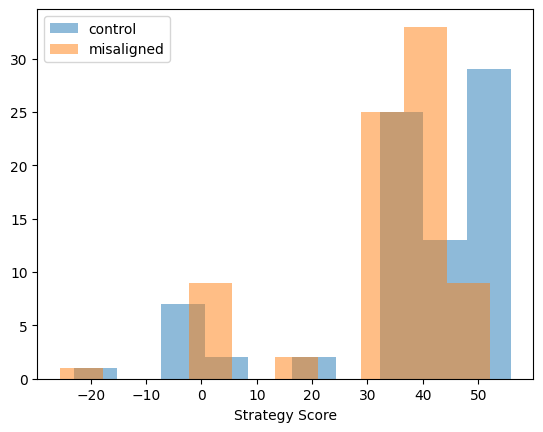

In [64]:
# Histogram of strategy scores
plt.figure()
control_counts, control_bins, _ = plt.hist(strategy_scores_control.values(), alpha=0.5, label='control')
mis_counts, mis_bins, _ = plt.hist(strategy_scores_mis.values(), alpha=0.5, label='misaligned')
plt.legend()
plt.xlabel("Strategy Score")
plt.show()

In [65]:
# Creating the strategy score dataframes

strategy_scores_mis_list = [[k,v] for k,v in strategy_scores_mis.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

mis_cluster_df = pd.DataFrame(strategy_scores_mis_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
mis_cluster_df['scoreScaled'] = (mis_cluster_df['score'] - mis_cluster_df['score'].min()) / (mis_cluster_df['score'].max() - mis_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())


In [66]:
# Cluster the strategy scores

init_guesses = [0.6,0.5,0.4]
init_guesses = 3

mis_clusters = scipy.cluster.vq.kmeans(mis_cluster_df['scoreScaled'], k_or_guess=init_guesses)
mis_cluster_centers = sorted(mis_clusters[0], reverse=True)

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=init_guesses)
control_cluster_centers = sorted(control_clusters[0], reverse=True)

In [67]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

mis_clusters_repeated = np.repeat(np.expand_dims(mis_cluster_centers, axis=0), len(mis_cluster_df), axis=0)
mis_cluster_distances = (mis_clusters_repeated - np.repeat(np.expand_dims(np.array(mis_cluster_df['scoreScaled']), axis=1),repeats=len(mis_cluster_centers), axis=1))**2
mis_cluster_labels = np.argmin(mis_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [68]:
# Create dictionary of cluster labels:

mis_cluster_dict = { strat: cluster for (strat, cluster) in zip(mis_cluster_df.strategy, mis_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


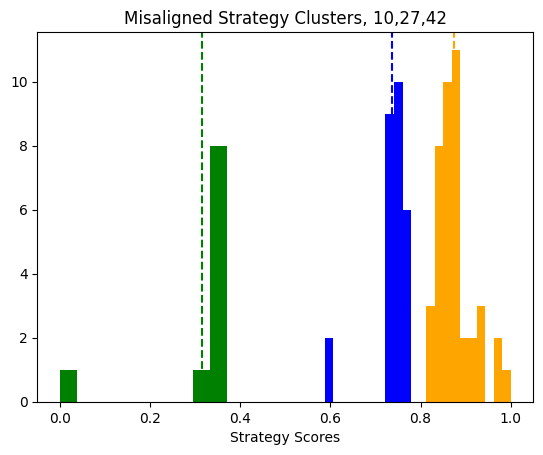

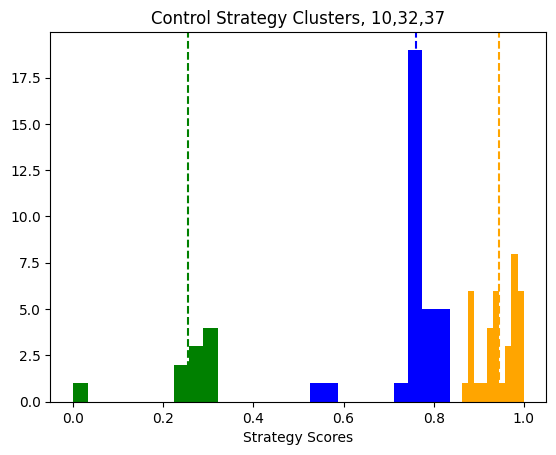

In [69]:
# Plotting the strategy clusters

plt.figure()
cluster_colors = ['orange', 'blue', 'green']
labels = ['adaptive', 'moderate', 'maladaptive']
cluster_sizes = []
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in mis_cluster_dict.items() if v == c]
    cluster_scores = [list(mis_cluster_df.loc[mis_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    plt.axvline(mis_cluster_centers[c], linestyle="--", color=cluster_colors[c])
    cluster_sizes.append(sum(value == c for value in mis_cluster_dict.values()))
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Misaligned Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")

cluster_sizes = []
plt.figure()
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in control_cluster_dict.items() if v == c]
    cluster_scores = [list(control_cluster_df.loc[control_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    cluster_sizes.append(sum(value == c for value in control_cluster_dict.values()))
    plt.axvline(control_cluster_centers[c], linestyle="--", color=cluster_colors[c])
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Control Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")
    
plt.show()

In [70]:
row

['61601e9a6b8306196d2a129c',
 '40',
 '[10206, 12909, 13494, 14013, 14557]',
 "['left', 'left', 'left', 'down', 'left']",
 'test',
 "['0', '0', '23', '24', '25', '30', '33']",
 "{'click': {'state': {'target': ['33', '6', '22'], 'time': [3156, 5075, 7652]}, 'edge': {'target': [], 'time': []}}, 'mouseover': {'state': {'target': ['23', '24', '25', '33', '33', '25', '24', '2', '4', '6', '16', '20', '19', '22'], 'time': [2333, 2351, 2533, 2716, 2983, 3699, 3718, 3883, 4000, 4200, 6633, 6916, 7316, 7366]}, 'edge': {'target': [], 'time': []}}, 'mouseout': {'state': {'target': ['0', '0', '23', '24', '25', '33', '33', '25', '24', '2', '4', '6', '16', '20', '19', '22'], 'time': [916, 1416, 2349, 2399, 2616, 2767, 3263, 3716, 3733, 3933, 4066, 6600, 6683, 7300, 7333, 16366]}, 'edge': {'target': [], 'time': []}}}",
 '[-2, 4, 2, 9, 46]',
 '[8492, 2190, 76, 28, 23]',
 '0',
 '0',
 '54.8',
 '[None, None, None]',
 "['', -1, 3, -7, 16, -32, -74, -48, 2, 10, 15, -30, 1, 1, -2, 10, 12, -83, 67, 13, -66, 47

In [71]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['condition'] == 0:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']]
    else:
        strategy_df.at[idx, 'cluster'] = mis_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_mis[row['strategy']]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [72]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [73]:
# Scaling by optimal scores
optimal_env_score = {
    0: 55.89,
    1: 52.14
}

In [74]:
all_trials_df["strategyScores_scaled"] = all_trials_df["strategyScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"]/optimal_env_score[1]

In [75]:
all_trials_df["expectedScores_scaled"] = all_trials_df["expectedScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"]/optimal_env_score[1]

In [76]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [77]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            9.00            0.00          0       0.000000             1  \
1           58.00            0.00          0       0.000000             2   
2           20.00            0.00          0       0.000000             3   
3          -14.00            0.00          0       0.000000             4   
4          -42.00            0.00          0       0.000000             5   
...           ...             ...        ...            ...           ...   
8395        46.70           46.70          2       5.000000            36   
8396        14.55           22.55          3       3.333333            37   
8397        46.40           59.40          4       3.750000            38   
8398        55.70           35.70          2       5.000000            39   
8399        74.85           81.85          1       5.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             1  6139d8c791c9b4805690b33e         0         0         0  \
1             1  6139d8c791c9b4805690b33e         0         0         0   
2             1  6139d8c791c9b4805690b33e         0         0         0   
3             1  6139d8c791c9b4805690b33e         0         0         0   
4             1  6139d8c791c9b4805690b33e         0         0         0   
...         ...                       ...       ...       ...       ...   
8395          1  6401e7719c0cc074162322fc         0         0         0   
8396          1  6401e7719c0cc074162322fc         0         0         0   
8397          1  6401e7719c0cc074162322fc         0         0         0   
8398          1  6401e7719c0cc074162322fc         0         0         0   
8399          1  6401e7719c0cc074162322fc         0         0         0   

      clicksL4  clicksL5  clickStratsValid  timeFirstAction  timeFirstClick   
0            0         0              True             4692             NaN  \
1            0         0              True             5214             NaN   
2            0         0              True             3907             NaN   
3            0         0              True             2621             NaN   
4            0         0              True             2776             NaN   
...        ...       ...               ...              ...             ...   
8395         0         2              True             8761          2082.0   
8396         0         2              True            11593          2008.0   
8397         0         3              True            15365          1896.0   
8398         0         2              True             8517          1596.0   
8399         0         1              True             5294          1631.0   

     strategy cluster  strategyScores  strategyScores_scaled   
0          30       2    7.216450e-16           1.384052e-17  \
1          30       2    7.216450e-16           1.384052e-17   
2          30       2    7.216450e-16           1.384052e-17   
3          30       2    7.216450e-16           1.384052e-17   
4          30       2    7.216450e-16           1.384052e-17   
...       ...     ...             ...                    ...   
8395       21       0    4.245204e+01           8.141933e-01   
8396       21       0    4.245204e+01           8.141933e-01   
8397       21       0    4.245204e+01           8.141933e-01   
8398       21       0    4.245204e+01           8.141933e-01   
8399       21       0    4.245204e+01           8.141933e-01   

      expectedScores_scaled  
0                  0.000000  
1                  0.000000  
2                  0.000000  
3                  0.000000  
4                  0.000000  
...                     ...  
8395               0.895666  
8396               0.432489  
8397               1.139241  
8398               0.684695  
8399               1.569812  

[8400 rows x 20 columns]

# Visualizing Data

## Expected Scores

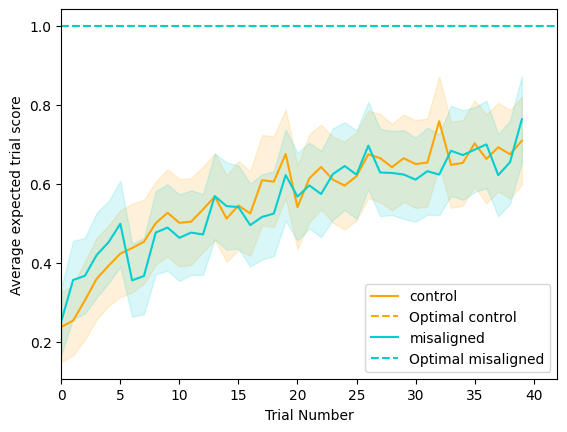

In [78]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Actual Scores

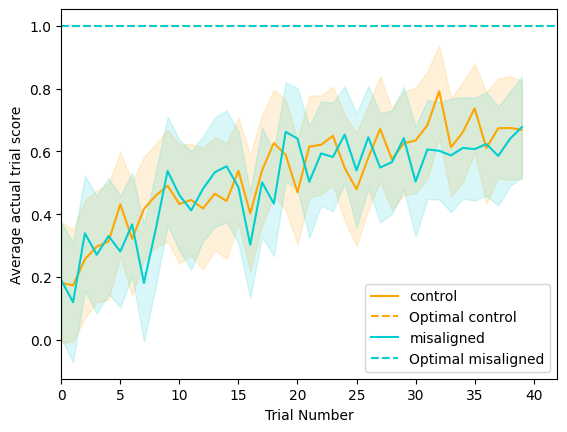

In [79]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"

optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average actual trial score")
plt.show()



## Clicks

In [80]:
val = 50000
metric="timeFirstAction"
print(len(filtered_data.loc[filtered_data[metric] > val]))
#print(filtered_data.loc[filtered_data.timeToClick > val].groupby("workerId").count()[metric])
filtered_data.loc[filtered_data[metric] > val][["workerId", "trialNumbers", metric]]

199


workerId  trialNumbers  timeFirstAction
47    60f724fd8ec131e82a00b129             8            52340
53    60f724fd8ec131e82a00b129            14            75312
62    60f724fd8ec131e82a00b129            23            51227
68    60f724fd8ec131e82a00b129            29            54134
71    60f724fd8ec131e82a00b129            32            55638
...                        ...           ...              ...
7943  61731b36eb6014947f8d2be7            24            56673
7945  61731b36eb6014947f8d2be7            26            50166
8207  60dcb953677e49a70004a4da             8            50352
8211  60dcb953677e49a70004a4da            12            61597
8235  60dcb953677e49a70004a4da            36            66286

[199 rows x 3 columns]

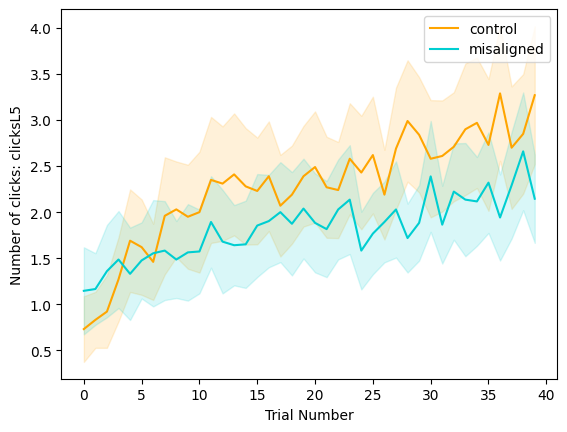

In [81]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Filter out participants whose click strategies are not valid
data_to_copy = data_to_copy.loc[data_to_copy.clickStratsValid]

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "clicksL5"
optimal_env_score = 5

num_parts = {}
performance_data = {}
full_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }
    full_data[cond] = data_to_copy.loc[data_to_copy.condition == idx]

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    
    #plt.hist(full_data[cond][performance_metric],label=cond, color=color_list[idx], alpha=0.5)
    #plt.scatter(full_data[cond]["trialNumbers"], full_data[cond][performance_metric], label=cond, color=color_list[idx])
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
#plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

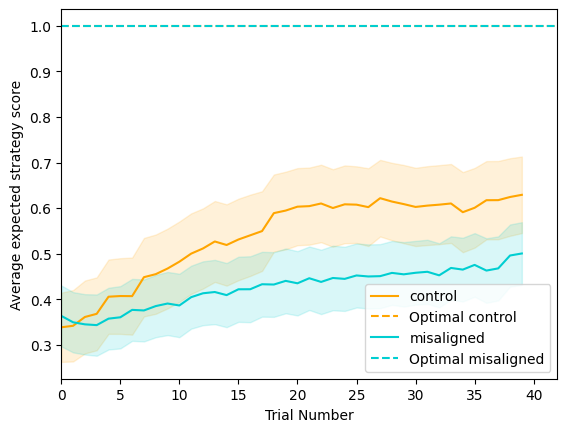

In [82]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "strategyScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}
# optimal_env_score = {
#     "control": 31.78,
#     "misaligned": 25.29
# }

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected strategy score")
plt.show()



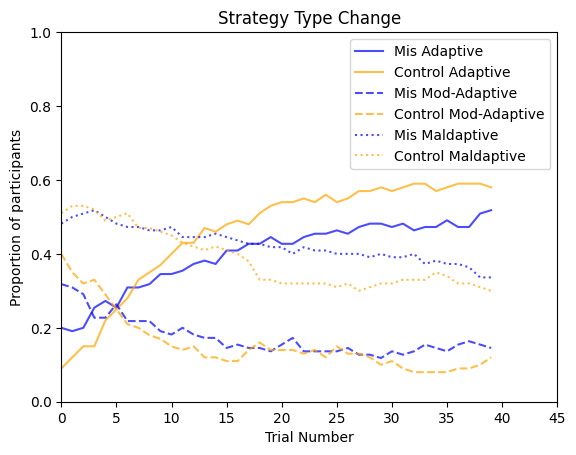

In [83]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Mis Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Mis Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Mis Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of participants")
plt.show()


# 0.1 - Transforming Response Data

In [84]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [85]:
# Selecting the response variable

response_vars = ["expectedScores", 'expectedScores_scaled', "strategyScores", 'strategyScores_scaled', 'avgClickLevel', "clicksL1", "clicksL5"]

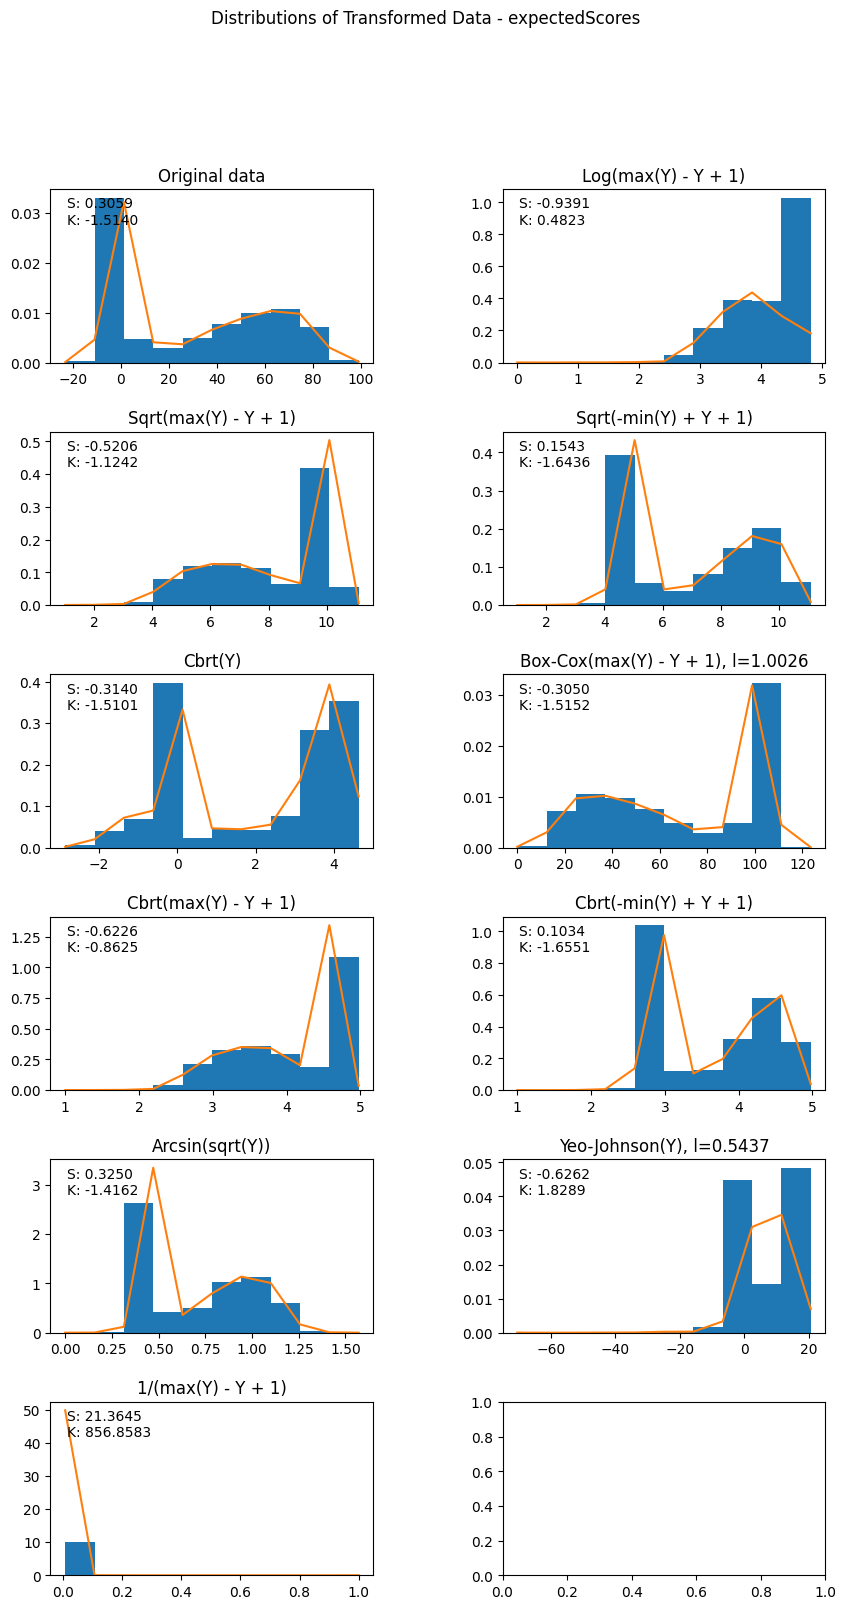

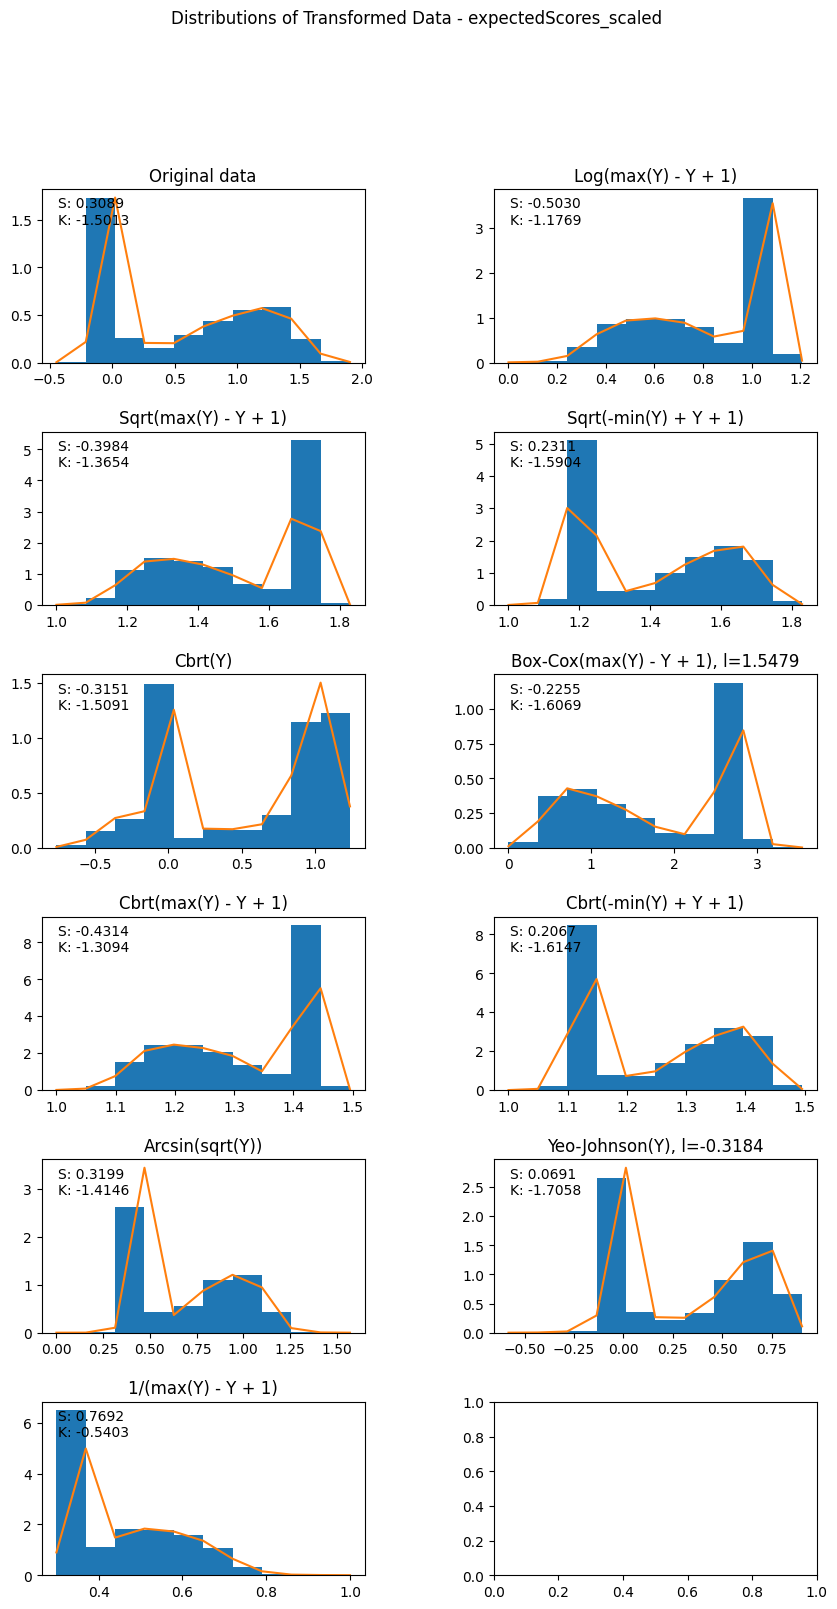

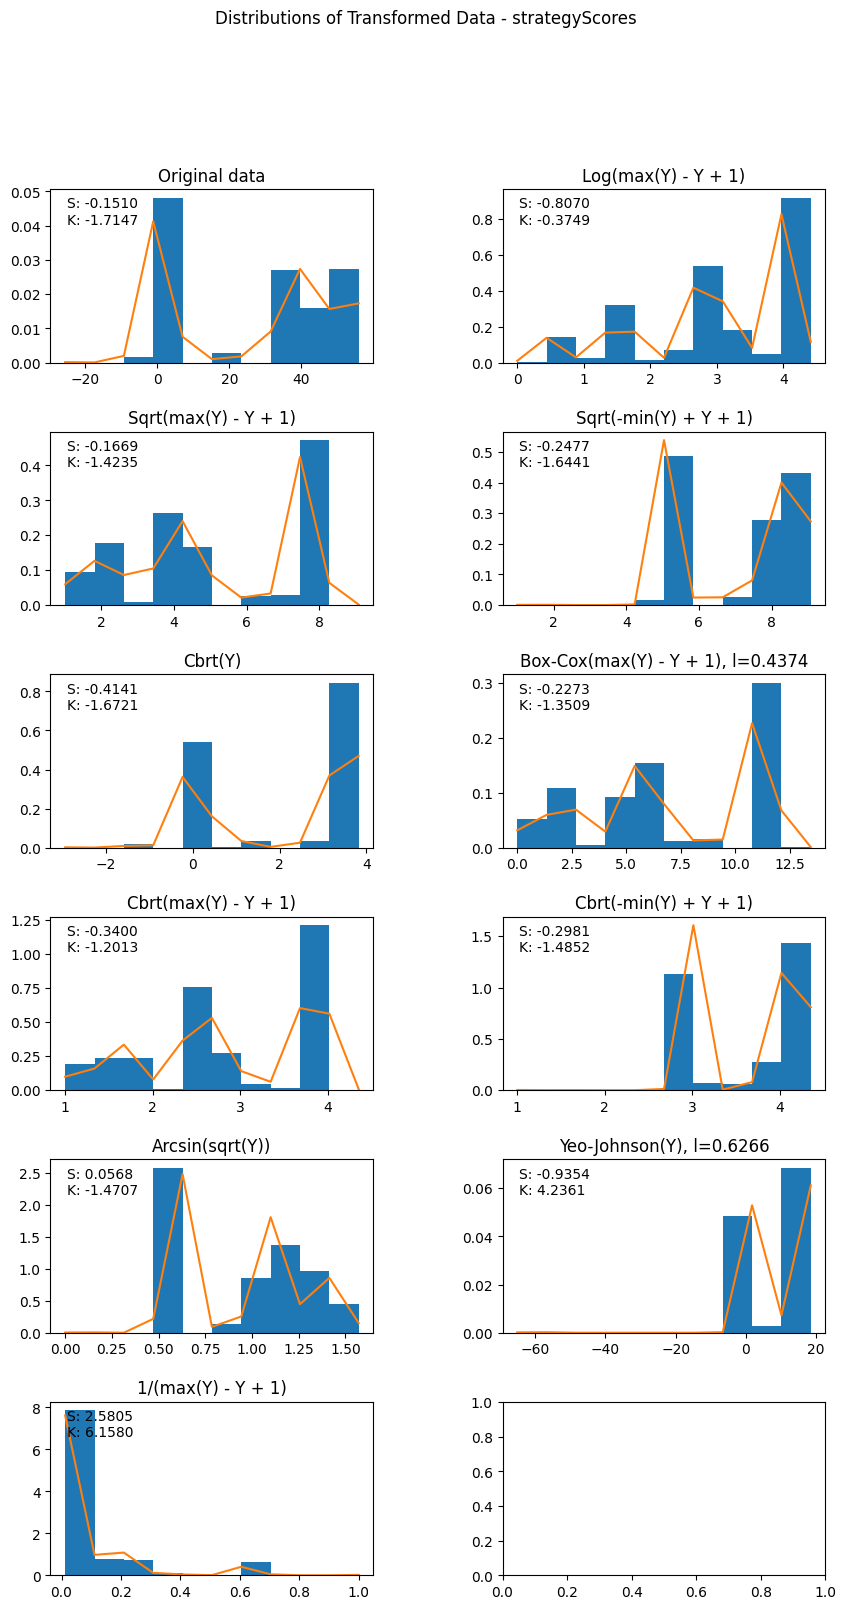

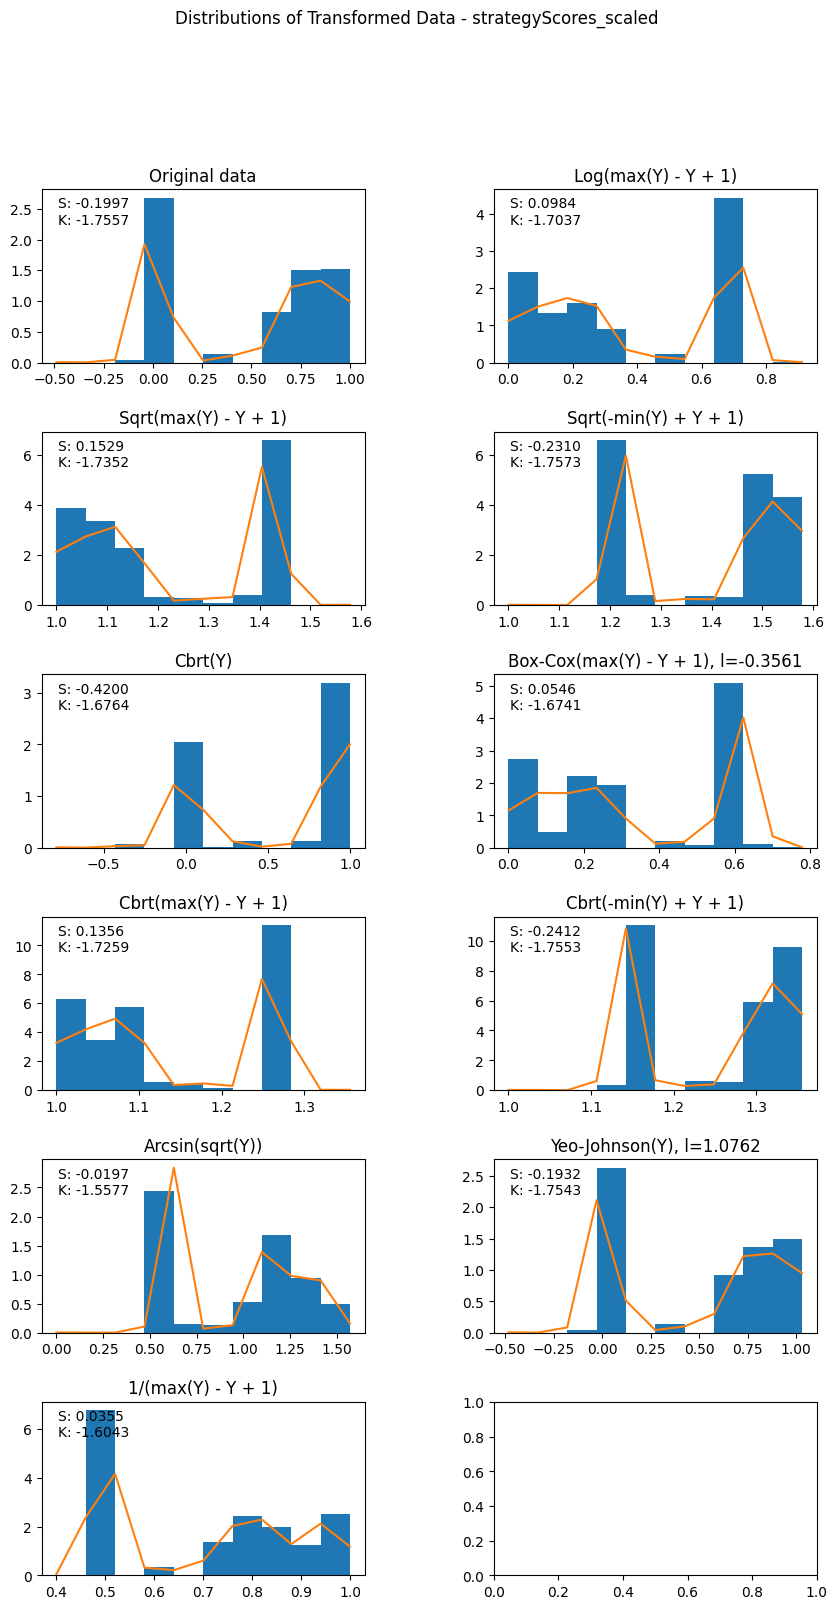

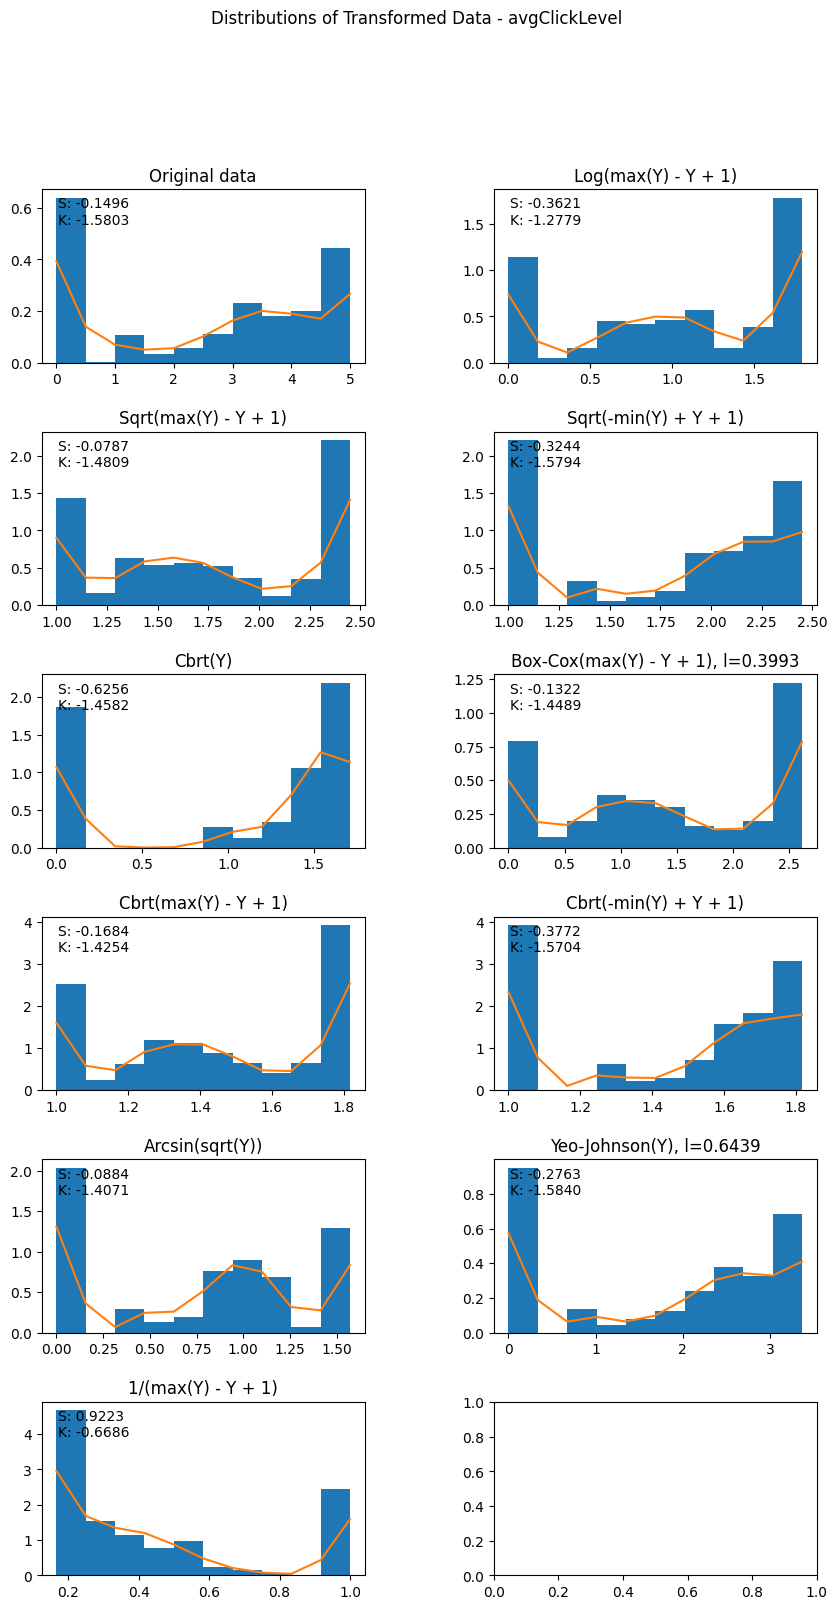

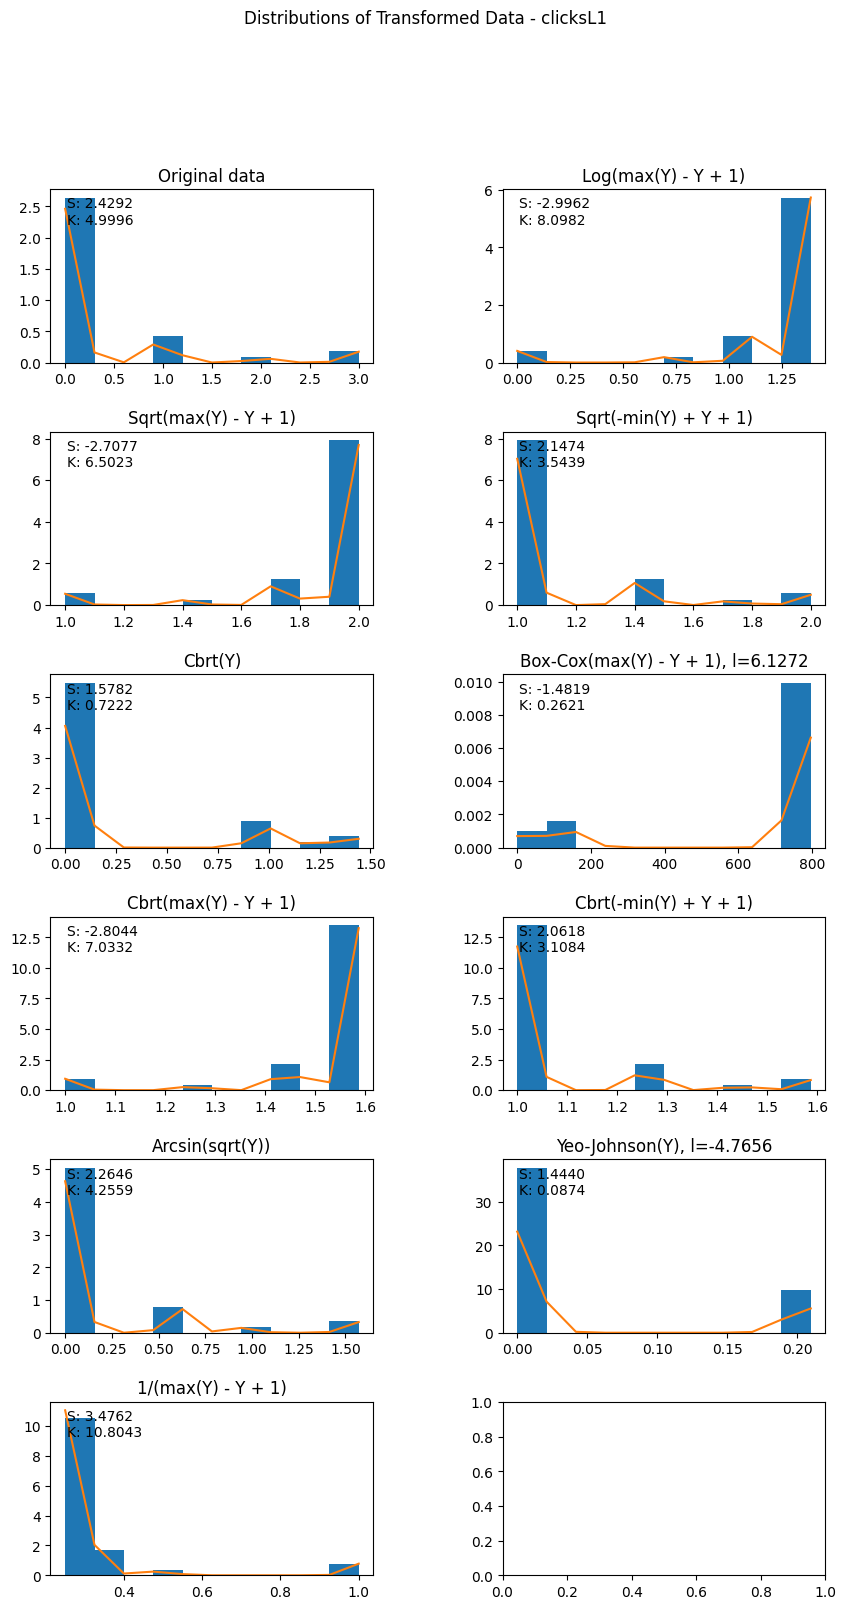

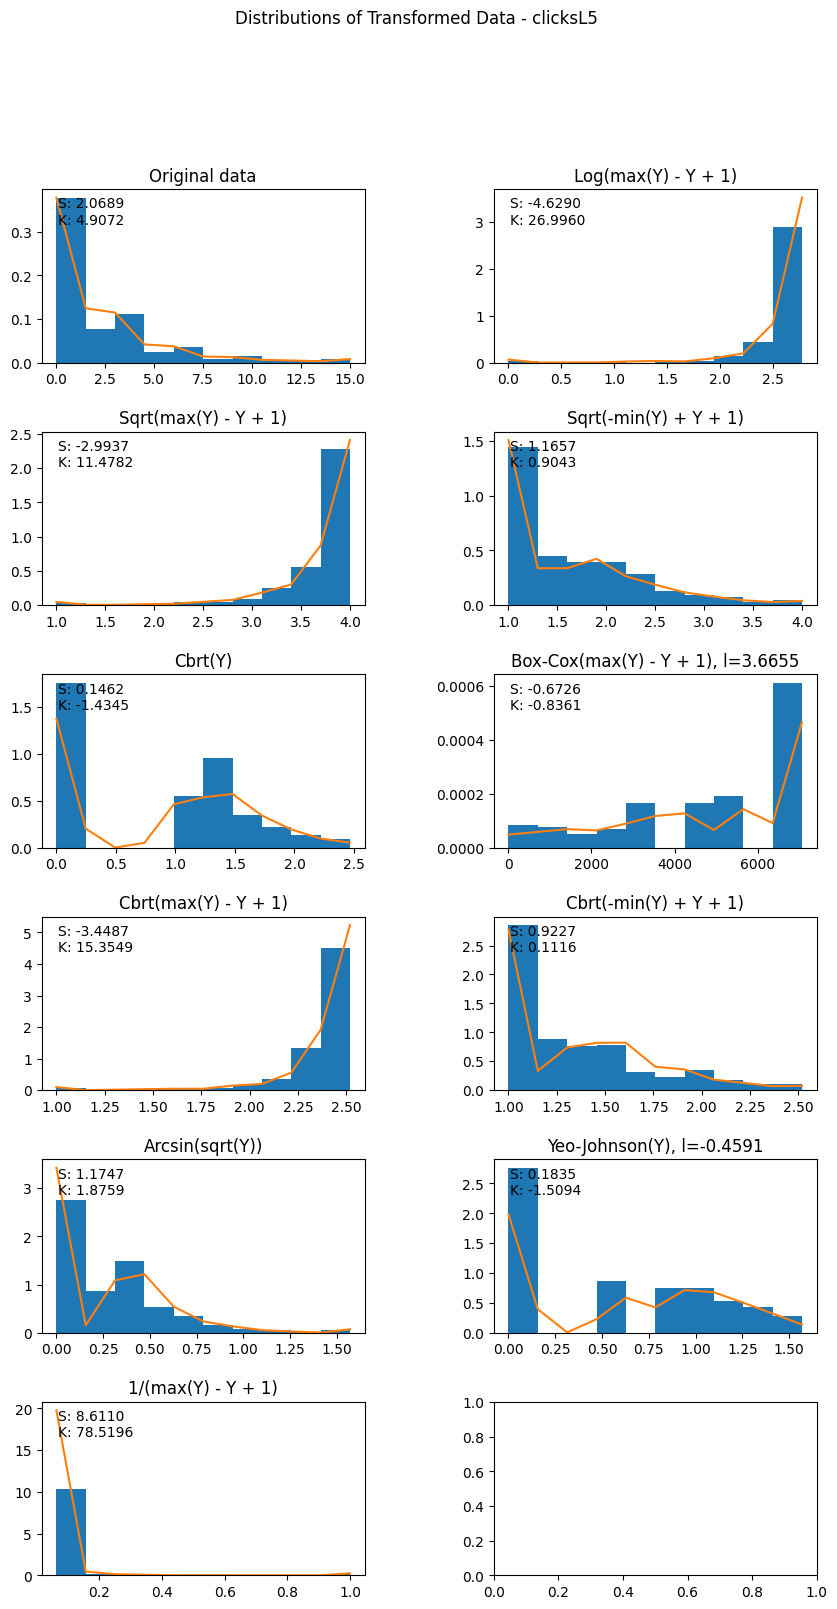

In [86]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

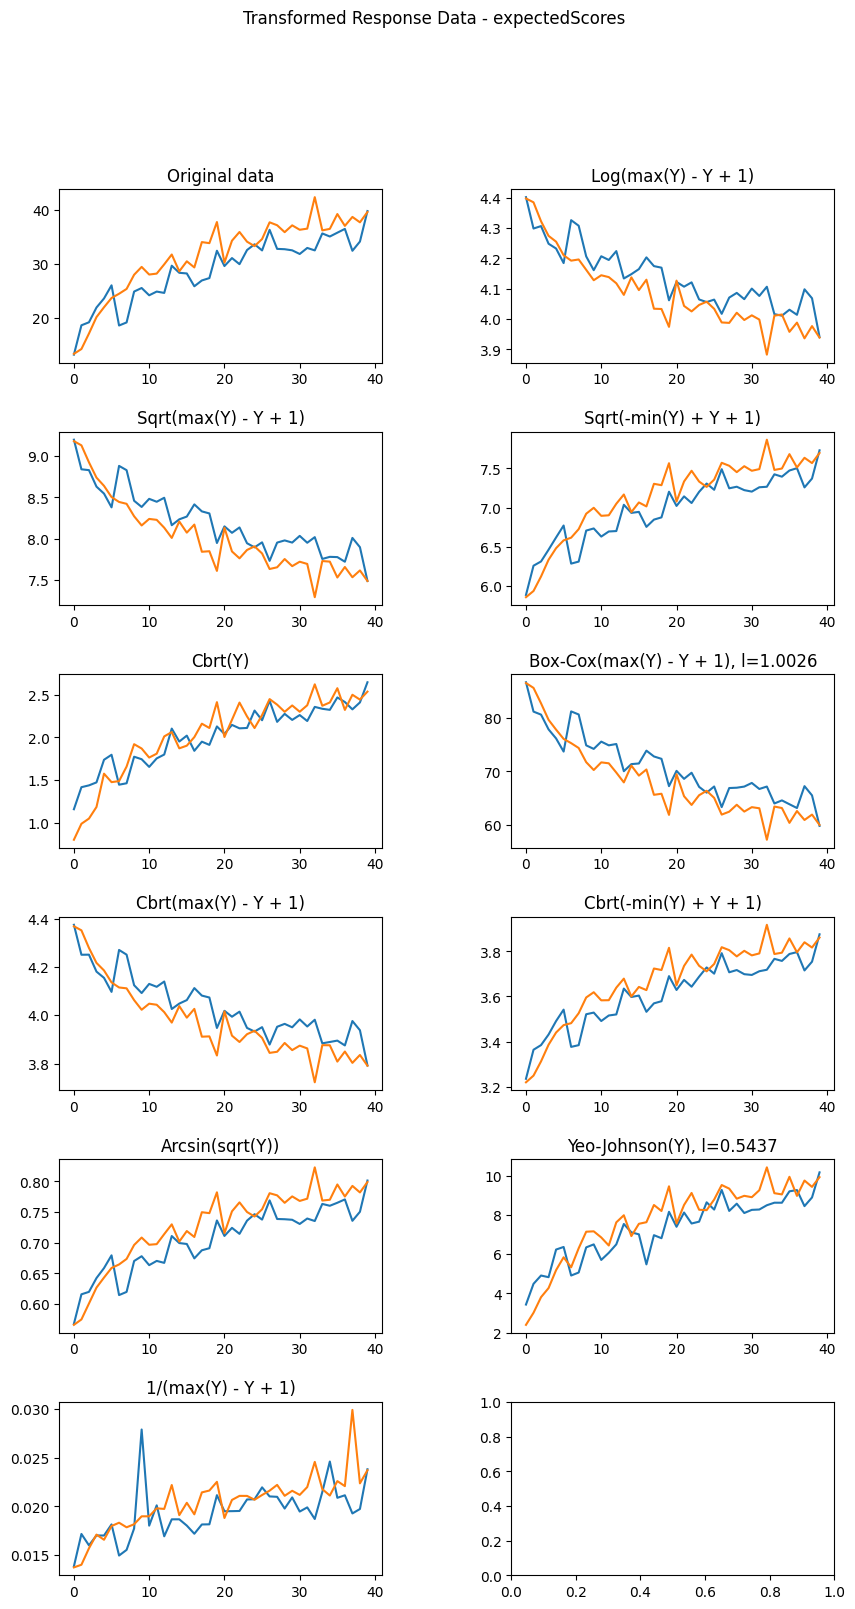

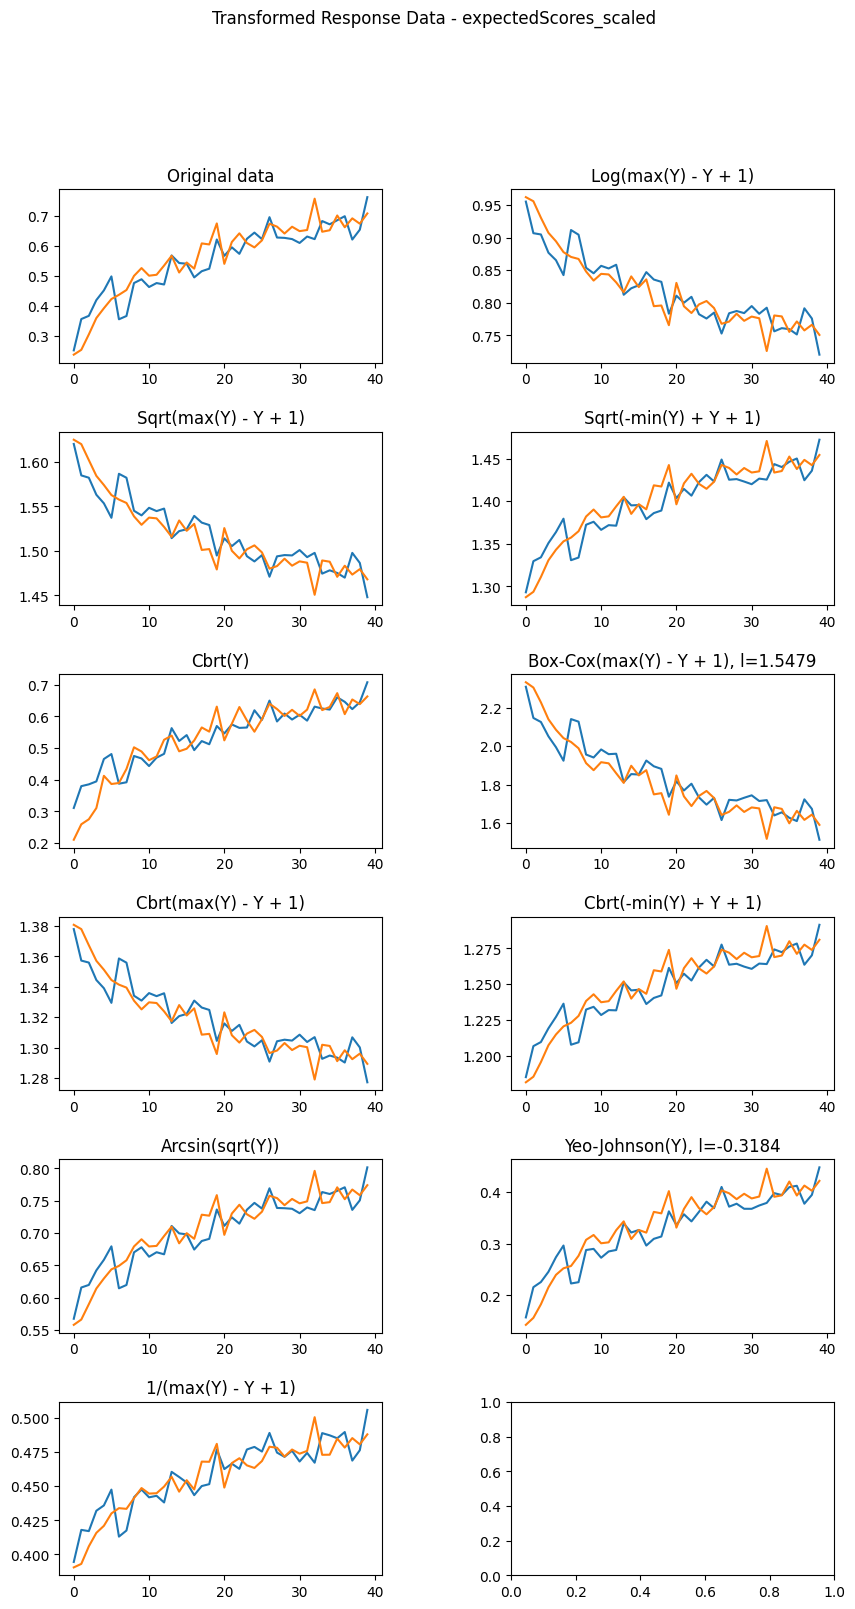

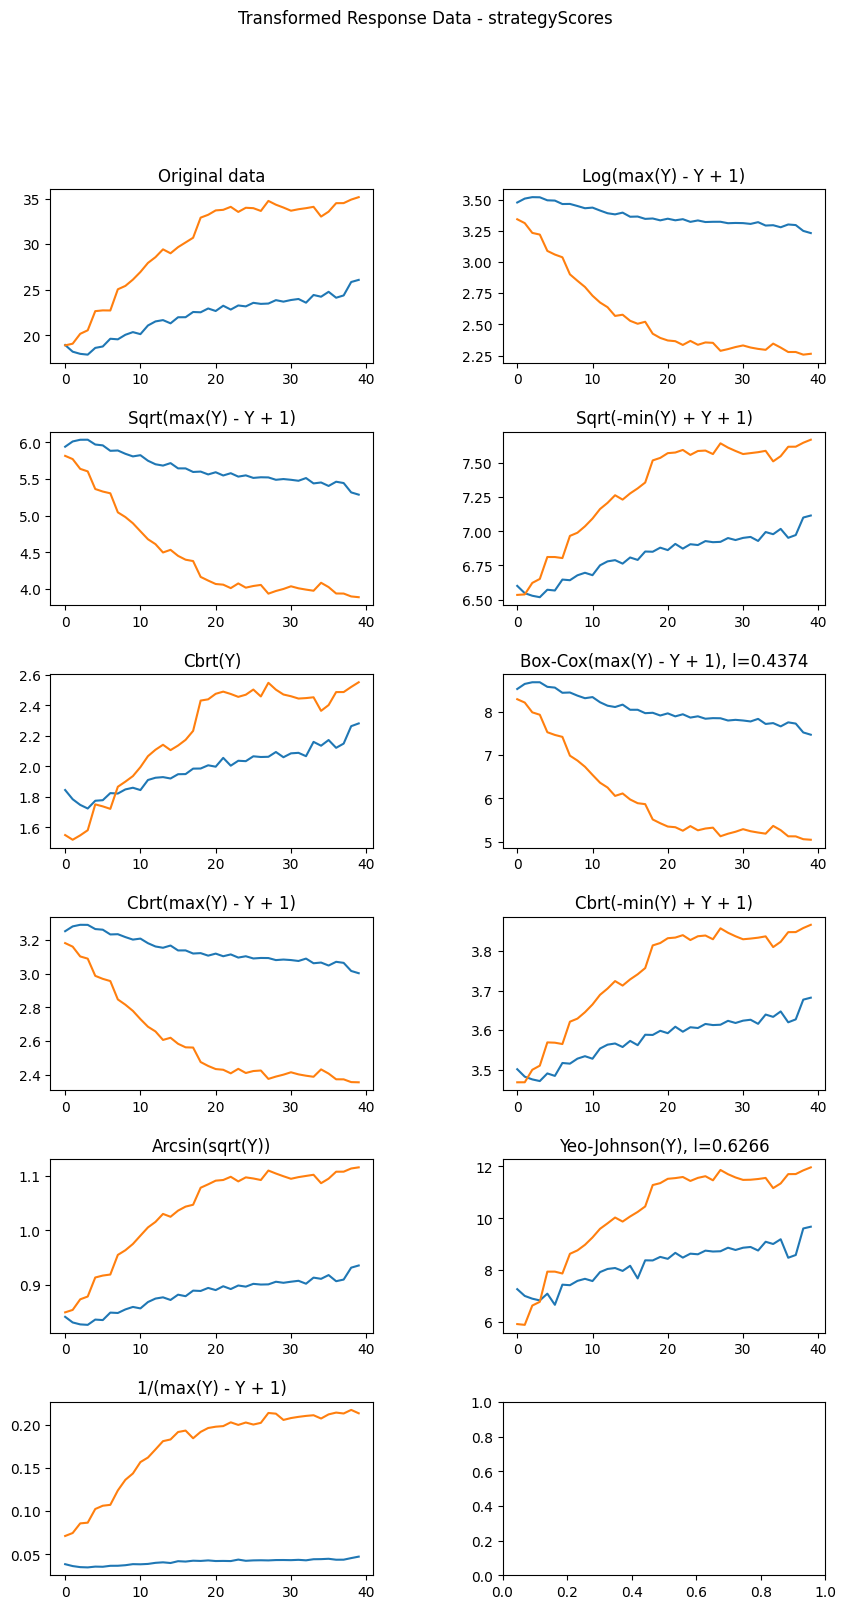

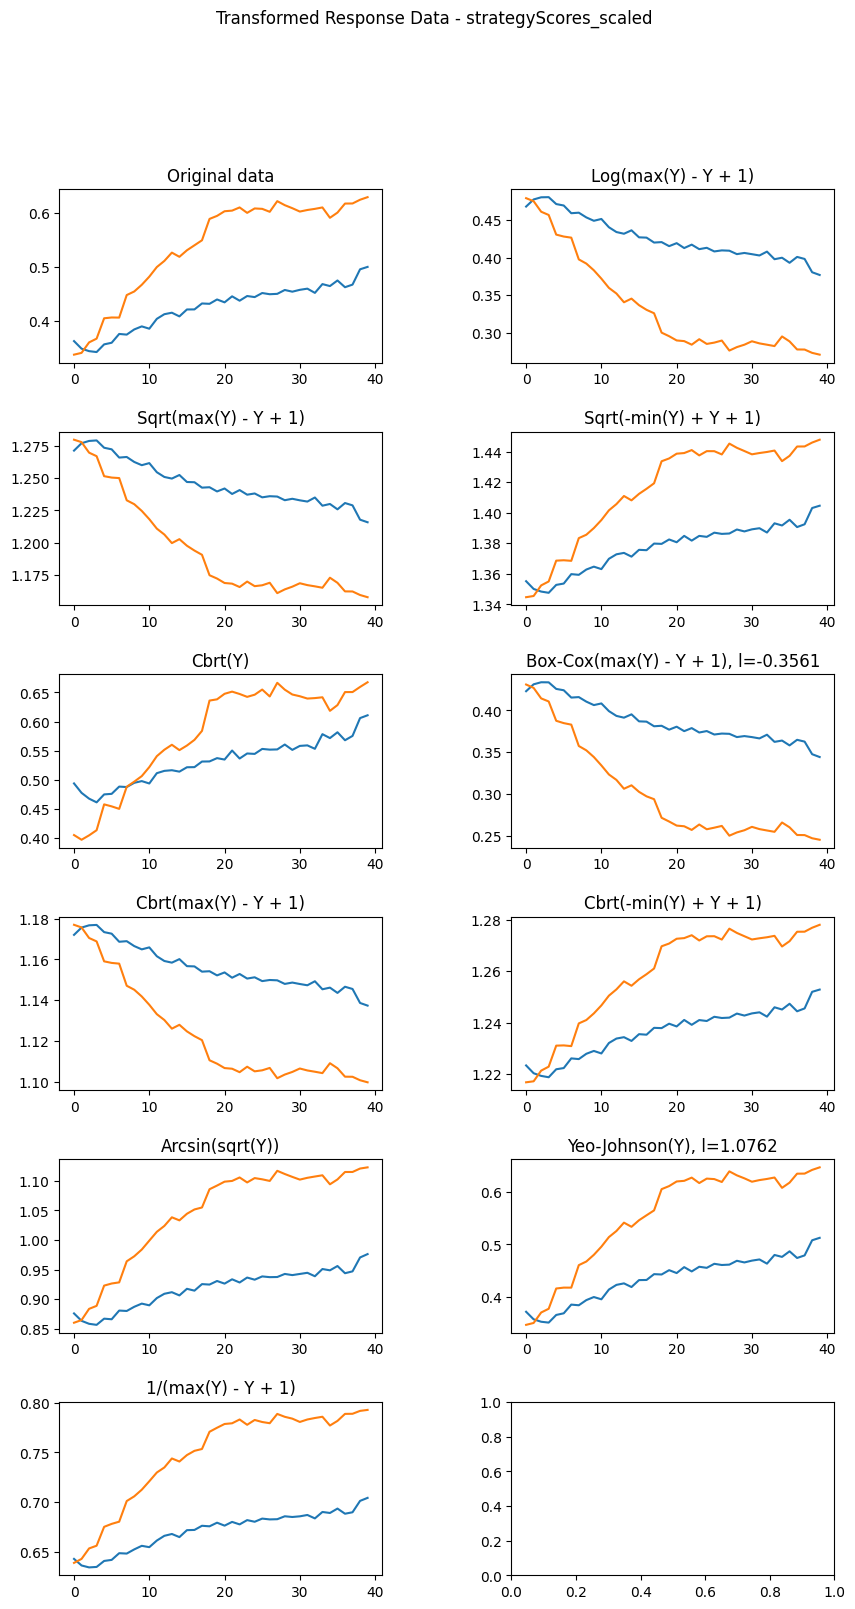

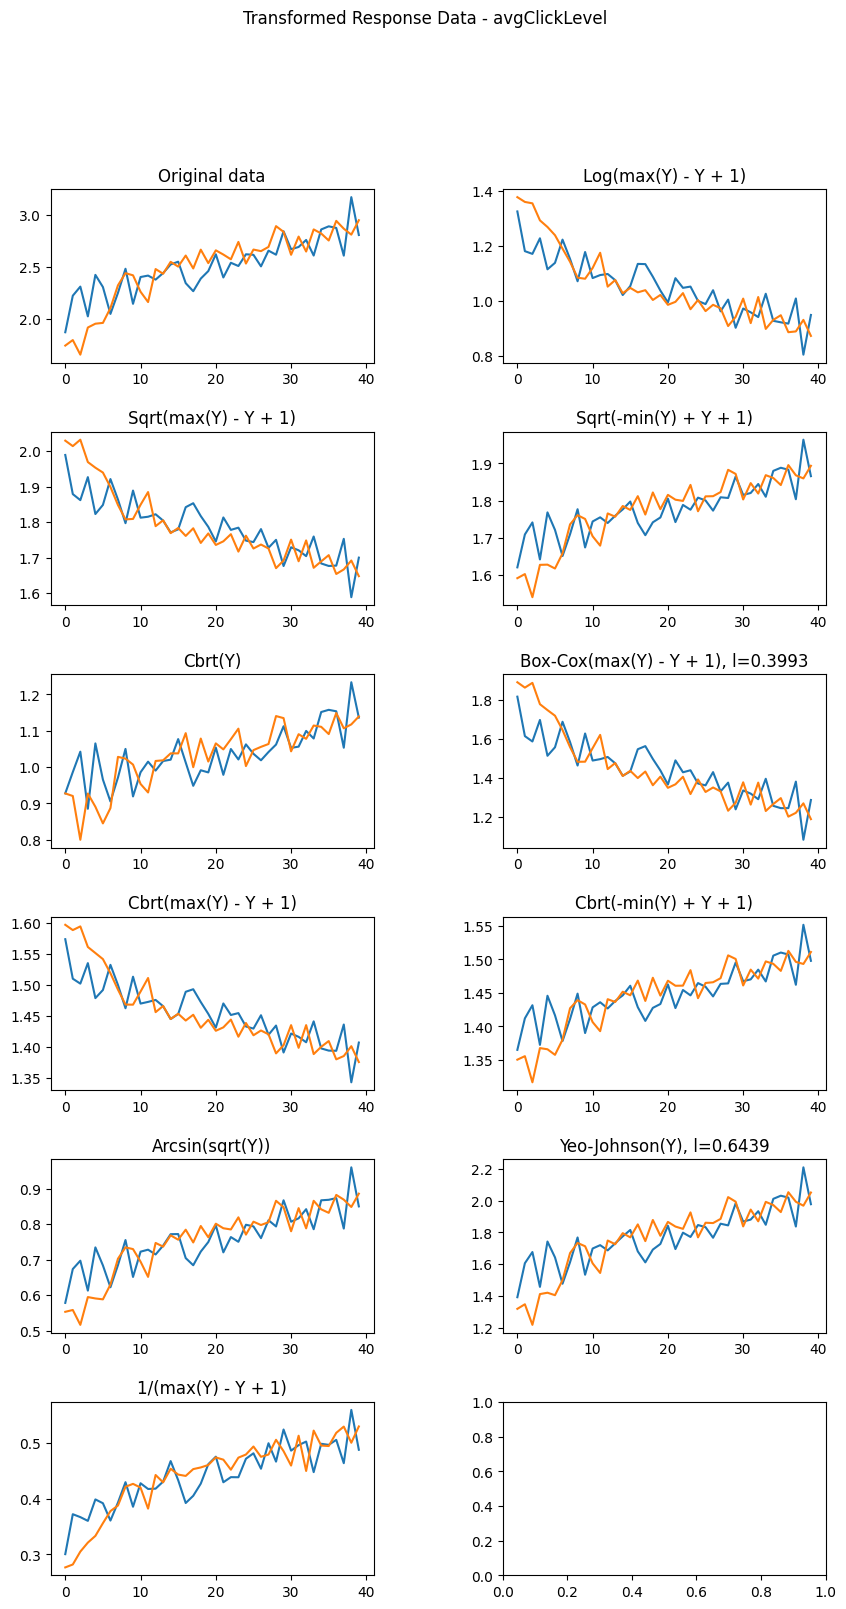

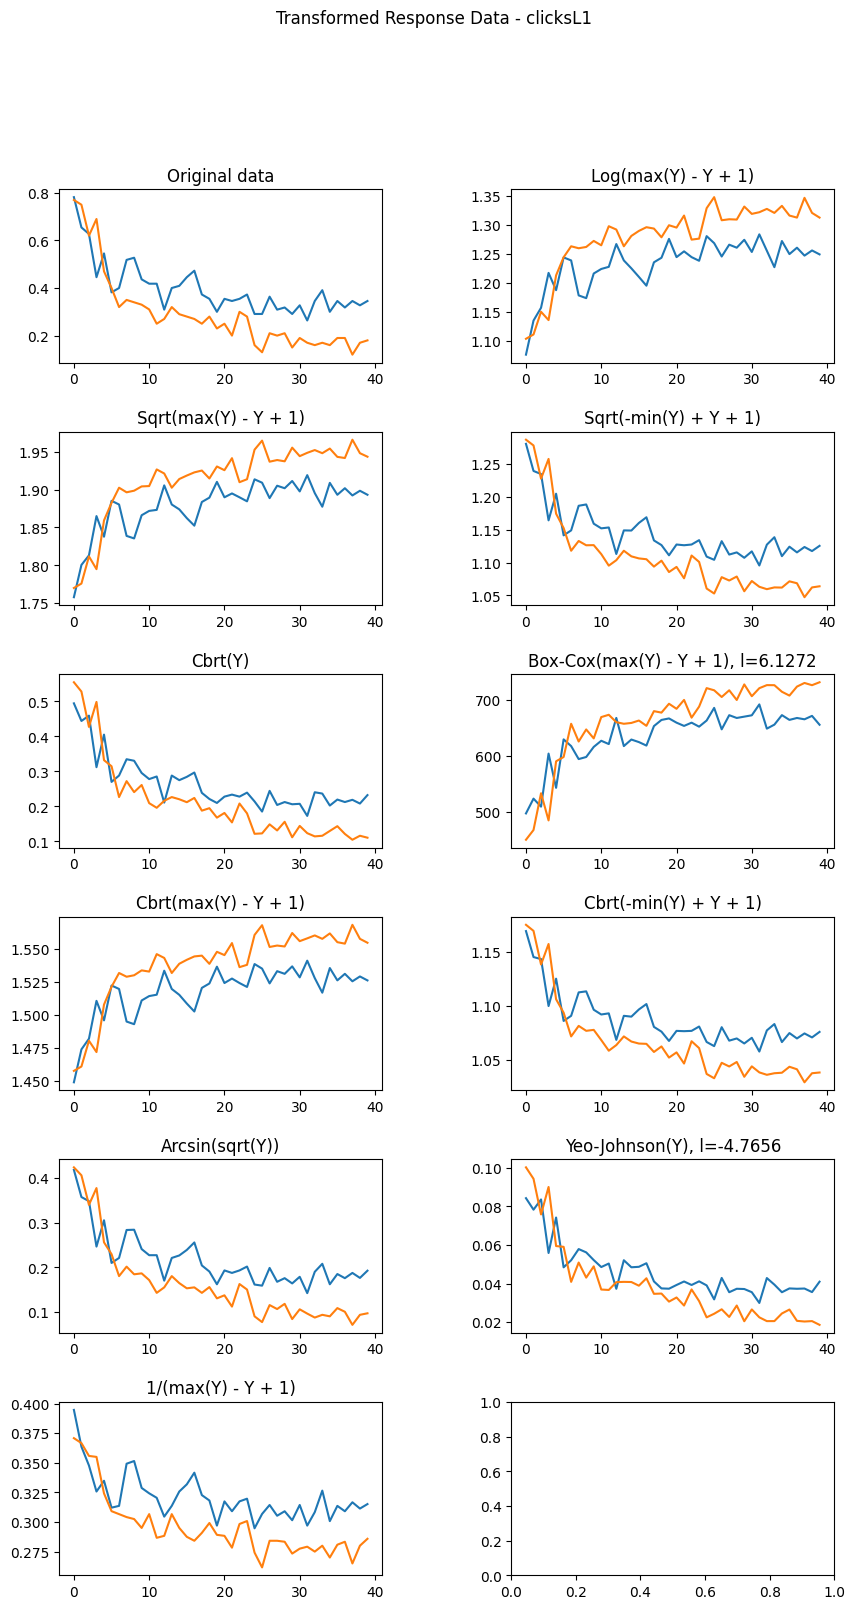

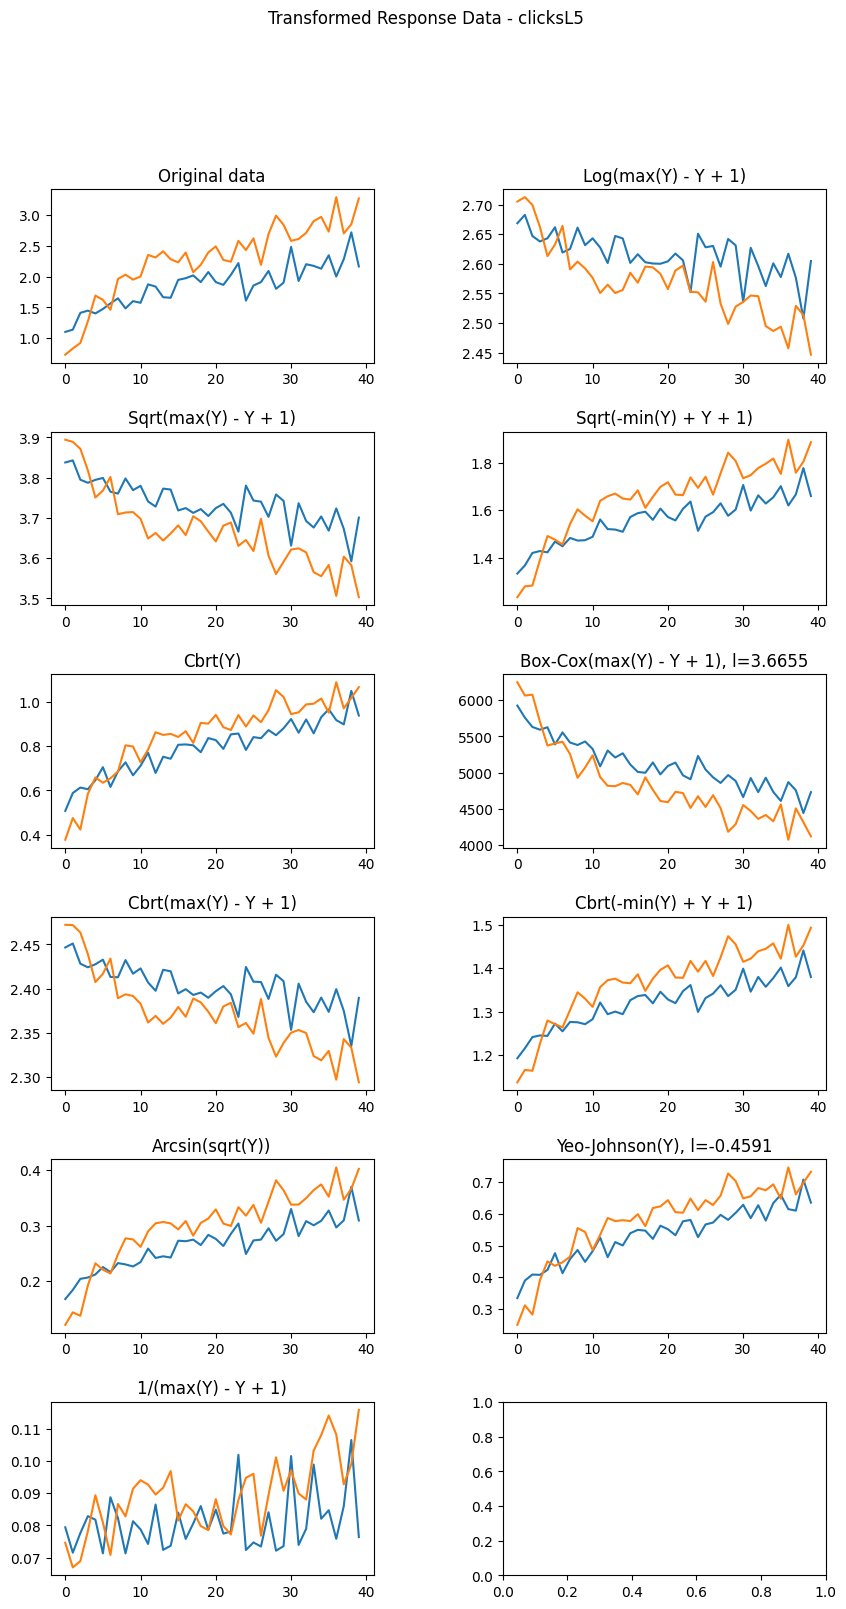

In [87]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [88]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [89]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    8400     Method:              REML          
No. Groups:          210      Scale:               459.6884      
Min. group size:     40       Log-Likelihood:      -37981.4744   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              14.612    2.625  5.567 0.000  9.467 19.756
C(trialNumbers)[T.2]    3.286    2.092  1.571 0.116 -0.815  7.387
C(trialNumbers)[T.3]    4.946    2.092  2.364 0.018  0.845  9.047
C(trialNumbers)[T.4]    7.841    2.092  3.747 0.000  3.740 11.942
C(trialNumbers)[T.5]    9.592    2.092  4.584 0.000  5.49


expectedScores - Sqrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8400     Method:              REML          
No. Groups:         210      Scale:               2.0848        
Min. group size:    40       Log-Likelihood:      -15438.9975   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              5.956    0.183 32.617 0.000  5.598  6.314
C(trialNumbers)[T.2]   0.233    0.141  1.655 0.098 -0.043  0.509
C(trialNumbers)[T.3]   0.350    0.141  2.484 0.013  0.074  0.626
C(trialNumbers)[T.4]   0.530    0.141  3.763 0.000  0.254  0.806
C(trialNumbers)[T.5]   0.683    0.141  4.845 0.000  0.407  0.95


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    8400     Method:              REML          
No. Groups:          210      Scale:               0.2591        
Min. group size:     40       Log-Likelihood:      -6691.8771    
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              4.337    0.058  74.834 0.000  4.224  4.451
C(trialNumbers)[T.2]  -0.073    0.050  -1.469 0.142 -0.170  0.024
C(trialNumbers)[T.3]  -0.107    0.050  -2.163 0.031 -0.205 -0.010
C(trialNumbers)[T.4]  -0.174    0.050  -3.497 0.000 -0.271 -0.076
C(trialNumbers)[T.5]  -0.202    0.050  -4.070 0.00


expectedScores - Yeo-Johnson(Y), l=0.5437:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8400     Method:              REML          
No. Groups:         210      Scale:               36.3433       
Min. group size:    40       Log-Likelihood:      -27358.4604   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              3.183    0.698  4.561 0.000  1.815  4.550
C(trialNumbers)[T.2]   0.847    0.588  1.440 0.150 -0.306  2.000
C(trialNumbers)[T.3]   1.448    0.588  2.462 0.014  0.295  2.602
C(trialNumbers)[T.4]   1.624    0.588  2.761 0.006  0.471  2.778
C(trialNumbers)[T.5]   2.800    0.588  4.759 0.000  1.647  3

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8400     Method:              REML          
No. Groups:         210      Scale:               0.0004        
Min. group size:    40       Log-Likelihood:      20903.4165    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.014    0.002  9.383 0.000  0.011  0.017
C(trialNumbers)[T.2]   0.002    0.002  1.006 0.315 -0.002  0.006
C(trialNumbers)[T.3]   0.002    0.002  1.108 0.268 -0.002  0.006
C(trialNumbers)[T.4]   0.003    0.002  1.754 0.079 -0.000  0.007
C(trialNumbers)[T.5]   0.003    0.002  1.616 0.106 -0.001  0.007
C


expectedScores_scaled - Sqrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0188               
Min. group size:  40      Log-Likelihood:     4260.0916            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.621    0.016  99.286 0.000  1.589  1.653
C(trialNumbers)[T.2]    -0.021    0.013  -1.563 0.118 -0.047  0.005
C(trialNumbers)[T.3]    -0.031    0.013  -2.303 0.021 -0.057 -0.005
C(trialNumbers)[T.4]    -0.049    0.013  -3.685 0.000 -0.076 -0.023
C(trialNumbers)[


expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.5479:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.3738               
Min. group size:  40      Log-Likelihood:     -8250.5846           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                2.310    0.076  30.366 0.000  2.161  2.459
C(trialNumbers)[T.2]    -0.098    0.060  -1.645 0.100 -0.215  0.019
C(trialNumbers)[T.3]    -0.146    0.060  -2.444 0.015 -0.263 -0.029
C(trialNumbers)[T.4]    -0.227    0.060  -3.804 0.000 -0.344 -0.110
C(t

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0065               
Min. group size:  40      Log-Likelihood:     8674.5022            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.379    0.010 144.305 0.000  1.360  1.397
C(trialNumbers)[T.2]    -0.012    0.008  -1.549 0.121 -0.028  0.003
C(trialNumbers)[T.3]    -0.018    0.008  -2.277 0.023 -0.033 -0.003
C(trialNumbers)[T.4]    -0.029    0.008  -3.659 0.000 -0.044 -0.013
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0067               
Min. group size:  40      Log-Likelihood:     8584.1490            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.185    0.010 116.258 0.000  1.165  1.205
C(trialNumbers)[T.2]     0.013    0.008   1.659 0.097 -0.002  0.029
C(trialNumbers)[T.3]     0.020    0.008   2.459 0.014  0.004  0.035
C(trialNumbers)[T.4]     0.030    0.008   3.791 0.000  0.015  0.046
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0093               
Min. group size:  40      Log-Likelihood:     7233.8107            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.392    0.011 37.140 0.000  0.371  0.413
C(trialNumbers)[T.2]      0.014    0.009  1.441 0.150 -0.005  0.032
C(trialNumbers)[T.3]      0.019    0.009  2.043 0.041  0.001  0.038
C(trialNumbers)[T.4]      0.032    0.009  3.376 0.001  0.013  0.050
C(trialNumbers)[T.


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    8400     Method:              REML          
No. Groups:          210      Scale:               1.0200        
Min. group size:     40       Log-Likelihood:      -12571.4548   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              5.262    0.204  25.814 0.000  4.863  5.662
C(trialNumbers)[T.2]   0.017    0.099   0.169 0.866 -0.177  0.210
C(trialNumbers)[T.3]  -0.035    0.099  -0.351 0.726 -0.228  0.159
C(trialNumbers)[T.4]  -0.051    0.099  -0.513 0.608 -0.244  0.143
C(trialNumbers)[T.5]  -0.199    0.099  -2.022 0.04


strategyScores - Box-Cox(max(Y) - Y + 1), l=0.4374:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    8400     Method:              REML          
No. Groups:          210      Scale:               2.7816        
Min. group size:     40       Log-Likelihood:      -16764.2413   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              7.345    0.336  21.847 0.000  6.686  8.004
C(trialNumbers)[T.2]   0.025    0.163   0.152 0.879 -0.294  0.344
C(trialNumbers)[T.3]  -0.063    0.163  -0.386 0.700 -0.382  0.256
C(trialNumbers)[T.4]  -0.089    0.163  -0.549 0.583 -0.408  0.230
C(trialNumbers)[T.5]  -0.337    0.163


strategyScores - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strategyScores
No. Observations:   8400     Method:              REML          
No. Groups:         210      Scale:               0.0215        
Min. group size:    40       Log-Likelihood:      3557.4872     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.925    0.030 31.288 0.000  0.867  0.983
C(trialNumbers)[T.2]  -0.003    0.014 -0.230 0.818 -0.031  0.025
C(trialNumbers)[T.3]   0.004    0.014  0.288 0.773 -0.024  0.032
C(trialNumbers)[T.4]   0.006    0.014  0.430 0.667 -0.022  0.034
C(trialNumbers)[T.5]   0.028    0.014  1.953 0.051 -0.000  0.056
C(tr


strategyScores_scaled - Original data:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0354               
Min. group size:  40      Log-Likelihood:     1470.7134            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.411    0.038 10.765 0.000  0.336  0.485
C(trialNumbers)[T.2]     -0.006    0.018 -0.314 0.753 -0.042  0.030
C(trialNumbers)[T.3]      0.001    0.018  0.058 0.954 -0.035  0.037
C(trialNumbers)[T.4]      0.003    0.018  0.189 0.850 -0.033  0.039
C(trialNumbers)[T.5]   


strategyScores_scaled - Sqrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0047               
Min. group size:  40      Log-Likelihood:     9921.0099            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.370    0.014 98.855 0.000  1.343  1.397
C(trialNumbers)[T.2]     -0.002    0.007 -0.341 0.733 -0.015  0.011
C(trialNumbers)[T.3]      0.000    0.007  0.020 0.984 -0.013  0.013
C(trialNumbers)[T.4]      0.001    0.007  0.139 0.890 -0.012  0.014
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0022               
Min. group size:  40      Log-Likelihood:     13023.2007           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.157    0.010 120.884 0.000  1.138  1.176
C(trialNumbers)[T.2]     0.001    0.005   0.271 0.786 -0.008  0.010
C(trialNumbers)[T.3]    -0.001    0.005  -0.136 0.892 -0.010  0.008
C(trialNumbers)[T.4]    -0.001    0.005  -0.288 0.774 -0.010  0.008
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0017               
Min. group size:  40      Log-Likelihood:     14184.2802           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.232    0.008 148.130 0.000  1.216  1.248
C(trialNumbers)[T.2]    -0.001    0.004  -0.349 0.727 -0.009  0.006
C(trialNumbers)[T.3]     0.000    0.004   0.008 0.994 -0.008  0.008
C(trialNumbers)[T.4]     0.000    0.004   0.123 0.902 -0.007  0.008
C(trialNumbers)


strategyScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8400    Method:             REML                 
No. Groups:       210     Scale:              0.0072               
Min. group size:  40      Log-Likelihood:     8141.1410            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.681    0.017 39.957 0.000  0.647  0.714
C(trialNumbers)[T.2]     -0.002    0.008 -0.188 0.851 -0.018  0.015
C(trialNumbers)[T.3]      0.002    0.008  0.295 0.768 -0.014  0.019
C(trialNumbers)[T.4]      0.004    0.008  0.483 0.629 -0.012  0.020
C(trialNumbers)[T.


avgClickLevel - Sqrt(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    8400     Method:              REML         
No. Groups:          210      Scale:               0.1527       
Min. group size:     40       Log-Likelihood:      -4505.5978   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.008    0.048 41.923 0.000  1.914  2.102
C(trialNumbers)[T.2]  -0.065    0.038 -1.705 0.088 -0.140  0.010
C(trialNumbers)[T.3]  -0.065    0.038 -1.713 0.087 -0.140  0.009
C(trialNumbers)[T.4]  -0.061    0.038 -1.610 0.107 -0.136  0.013
C(trialNumbers)[T.5]  -0.123    0.038 -3.236 0.001 -0.198 -0.049



avgClickLevel - Box-Cox(max(Y) - Y + 1), l=0.3993:
             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    8400     Method:              REML         
No. Groups:          210      Scale:               0.4988       
Min. group size:     40       Log-Likelihood:      -9449.7869   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.851    0.086 21.567 0.000  1.683  2.019
C(trialNumbers)[T.2]  -0.119    0.069 -1.723 0.085 -0.254  0.016
C(trialNumbers)[T.3]  -0.122    0.069 -1.764 0.078 -0.257  0.014
C(trialNumbers)[T.4]  -0.116    0.069 -1.680 0.093 -0.251  0.019
C(trialNumbers)[T.5]  -0.226    0.069 -3.282 0.001 -


avgClickLevel - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  avgClickLevel
No. Observations:   8400     Method:              REML         
No. Groups:         210      Scale:               0.1678       
Min. group size:    40       Log-Likelihood:      -4904.4620   
Max. group size:    40       Converged:           Yes          
Mean group size:    40.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.564    0.051 10.991 0.000  0.464  0.665
C(trialNumbers)[T.2]  0.052    0.040  1.313 0.189 -0.026  0.131
C(trialNumbers)[T.3]  0.045    0.040  1.121 0.262 -0.034  0.123
C(trialNumbers)[T.4]  0.038    0.040  0.948 0.343 -0.040  0.116
C(trialNumbers)[T.5]  0.100    0.040  2.499 0.012  0.022  0.178
C(trialNumbers)[T.6


clicksL1 - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    8400       Method:                REML      
No. Groups:          210        Scale:                 0.3171    
Min. group size:     40         Log-Likelihood:        -7545.0331
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.721    0.066  10.917 0.000  0.591  0.850
C(trialNumbers)[T.2]  -0.076    0.055  -1.386 0.166 -0.184  0.032
C(trialNumbers)[T.3]  -0.152    0.055  -2.773 0.006 -0.260 -0.045
C(trialNumbers)[T.4]  -0.214    0.055  -3.899 0.000 -0.322 -0.107
C(trialNumbers)[T.5]  -0.267    0.055  -4.853 0.000 -0.374 -0.1


clicksL1 - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     8400       Method:                REML     
No. Groups:           210        Scale:                 0.0384   
Min. group size:      40         Log-Likelihood:        1280.7680
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.265    0.023  54.661 0.000  1.220  1.310
C(trialNumbers)[T.2]  -0.026    0.019  -1.349 0.177 -0.063  0.012
C(trialNumbers)[T.3]  -0.052    0.019  -2.735 0.006 -0.090 -0.015
C(trialNumbers)[T.4]  -0.075    0.019  -3.919 0.000 -0.112 -0.037
C(trialNumbers)[T.5]  -0.093    0.019  -4.886 0.000 -0.

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     8400       Method:                REML     
No. Groups:           210        Scale:                 0.0112   
Min. group size:      40         Log-Likelihood:        6426.7030
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.464    0.012 119.572 0.000  1.440  1.488
C(trialNumbers)[T.2]   0.015    0.010   1.420 0.156 -0.006  0.035
C(trialNumbers)[T.3]   0.028    0.010   2.733 0.006  0.008  0.049
C(trialNumbers)[T.4]   0.039    0.010   3.795 0.000  0.019  0.059
C(trialNumbers)[T.5]   0.049    0.010   4.705 0.000  0.0

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Yeo-Johnson(Y), l=-4.7656:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    8400       Method:                REML      
No. Groups:          210        Scale:                 0.0036    
Min. group size:     40         Log-Likelihood:        11162.6026
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.088    0.007  12.624 0.000  0.074  0.101
C(trialNumbers)[T.2]  -0.006    0.006  -1.015 0.310 -0.017  0.006
C(trialNumbers)[T.3]  -0.012    0.006  -2.044 0.041 -0.023 -0.000
C(trialNumbers)[T.4]  -0.020    0.006  -3.369 0.001 -0.031 -0.008
C(trialNumbers)[T.5]  -0.025    0.006  -4.213 0.000


clicksL5 - Log(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8400      Method:               REML      
No. Groups:           210       Scale:                0.0898    
Min. group size:      40        Log-Likelihood:       -2194.6514
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.662    0.028 94.187 0.000  2.607  2.717
C(trialNumbers)[T.2]   0.011    0.029  0.372 0.710 -0.046  0.068
C(trialNumbers)[T.3]  -0.014    0.029 -0.480 0.631 -0.071  0.043
C(trialNumbers)[T.4]  -0.037    0.029 -1.250 0.211 -0.094  0.021
C(trialNumbers)[T.5]  -0.057    0.029 -1.952 0.051 -0.114  0.000
C(tria


clicksL5 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8400      Method:               REML      
No. Groups:           210       Scale:                0.2574    
Min. group size:      40        Log-Likelihood:       -6705.8128
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.475    0.066  7.148 0.000  0.345  0.605
C(trialNumbers)[T.2]   0.089    0.050  1.789 0.074 -0.008  0.186
C(trialNumbers)[T.3]   0.077    0.050  1.552 0.121 -0.020  0.174
C(trialNumbers)[T.4]   0.149    0.050  3.019 0.003  0.052  0.247
C(trialNumbers)[T.5]   0.206    0.050  4.155 0.000  0.109  0.303
C(trialNumbers)[T.


clicksL5 - Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8400      Method:               REML      
No. Groups:           210       Scale:                0.0726    
Min. group size:      40        Log-Likelihood:       -1385.9307
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.191    0.032 37.106 0.000  1.128  1.254
C(trialNumbers)[T.2]   0.026    0.026  0.973 0.330 -0.026  0.077
C(trialNumbers)[T.3]   0.038    0.026  1.453 0.146 -0.013  0.090
C(trialNumbers)[T.4]   0.070    0.026  2.655 0.008  0.018  0.121
C(trialNumbers)[T.5]   0.095    0.026  3.600 0.000  0.043  0.146
C(tr


clicksL5 - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5 
No. Observations:    8400       Method:                REML     
No. Groups:          210        Scale:                 0.0074   
Min. group size:     40         Log-Likelihood:        8301.2738
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.081    0.007 11.415 0.000  0.067  0.095
C(trialNumbers)[T.2]  -0.008    0.008 -0.921 0.357 -0.024  0.009
C(trialNumbers)[T.3]  -0.004    0.008 -0.433 0.665 -0.020  0.013
C(trialNumbers)[T.4]   0.004    0.008  0.419 0.675 -0.013  0.020
C(trialNumbers)[T.5]   0.008    0.008  0.983 0.326 -0.008  0.025
C(trial

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


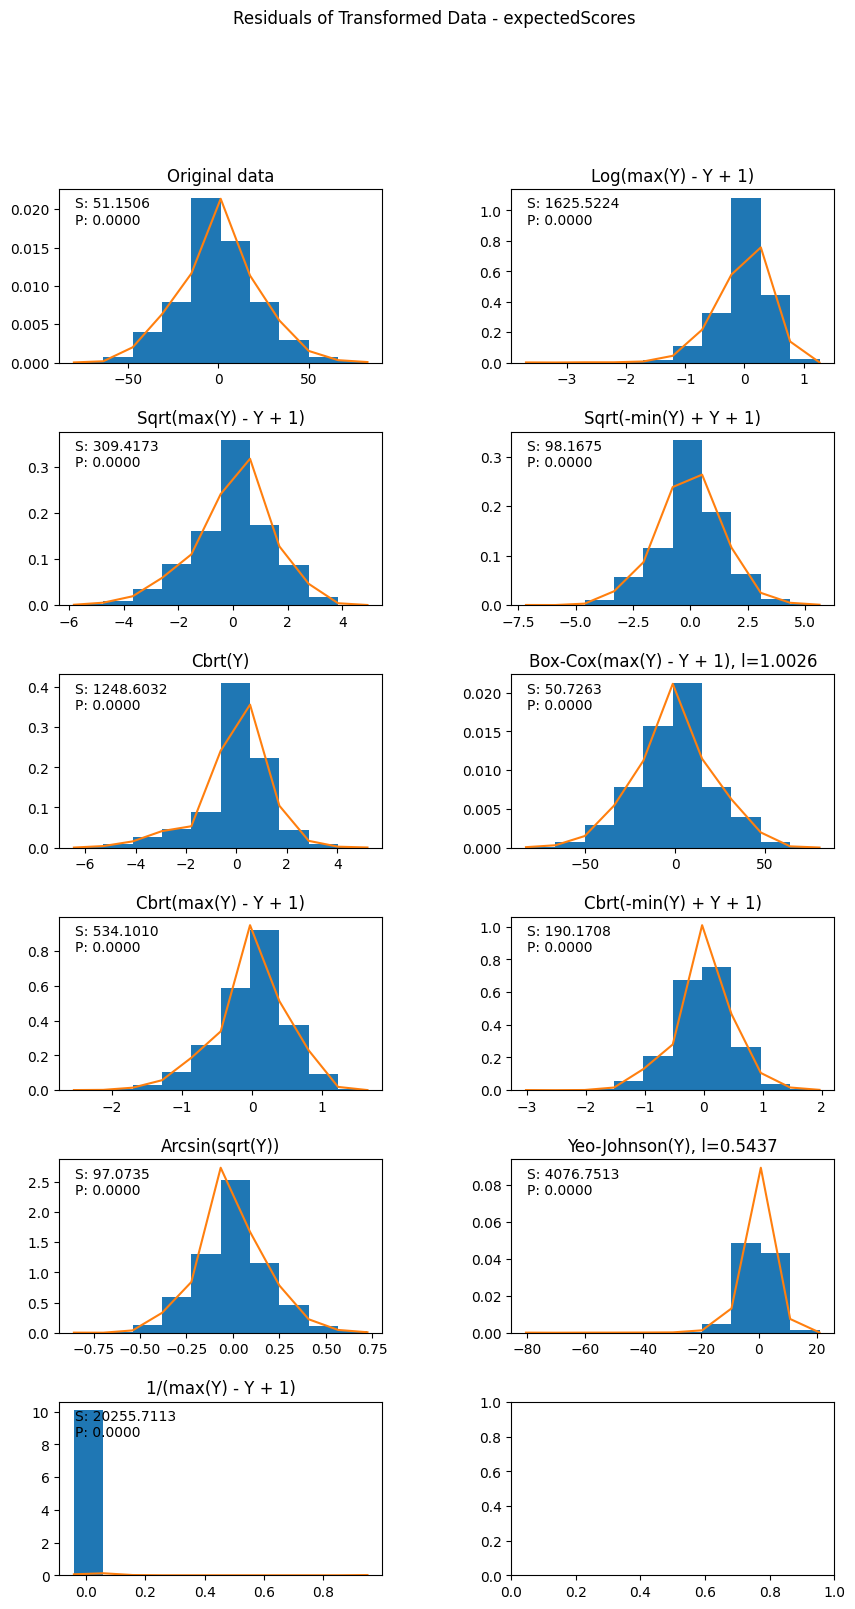

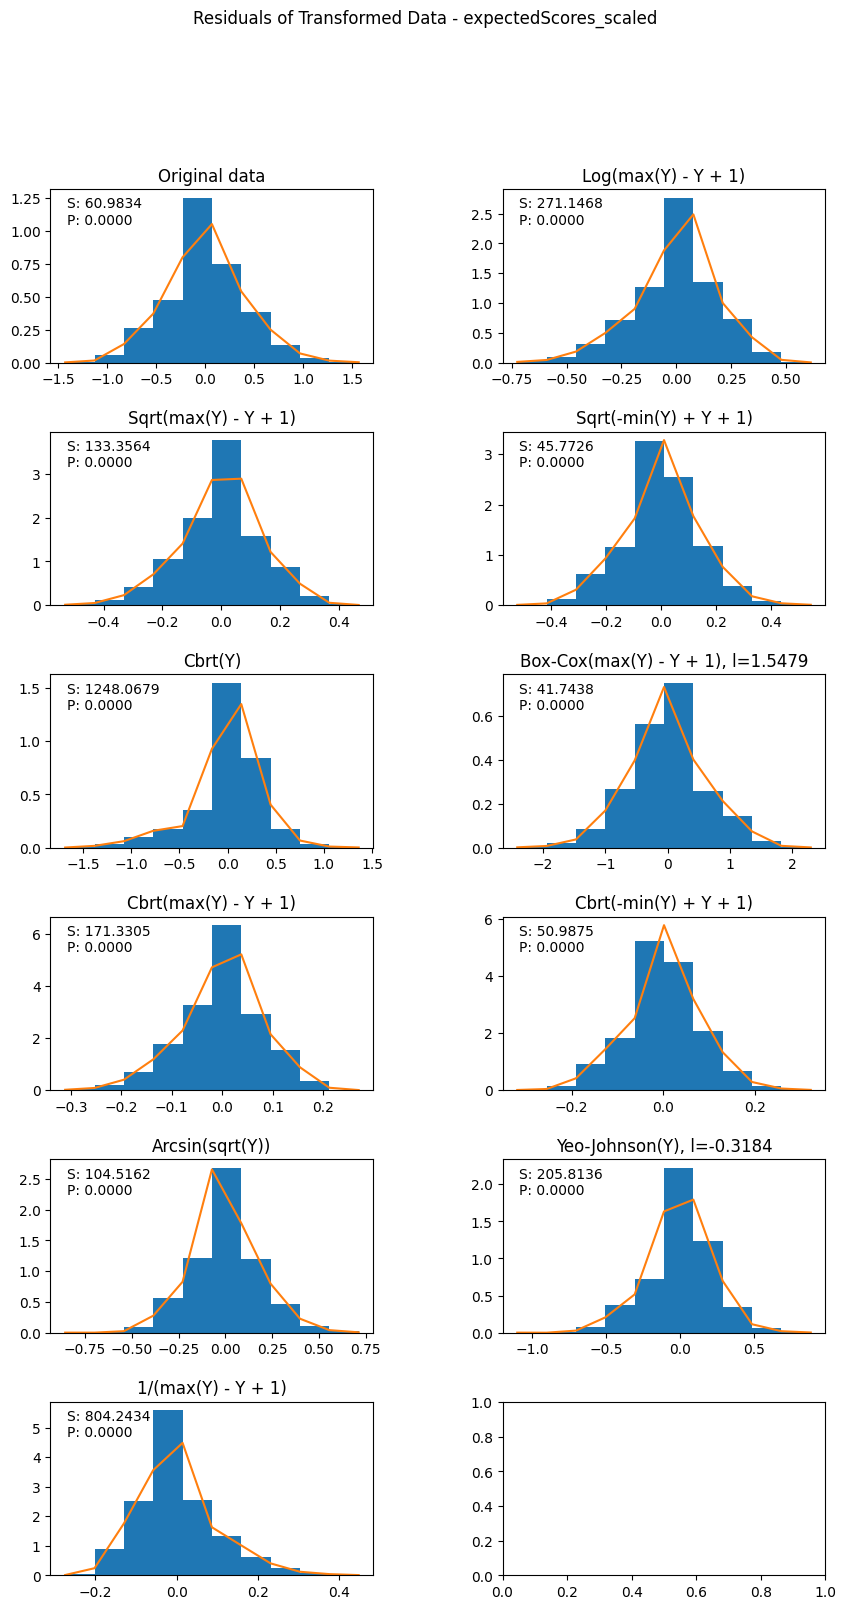

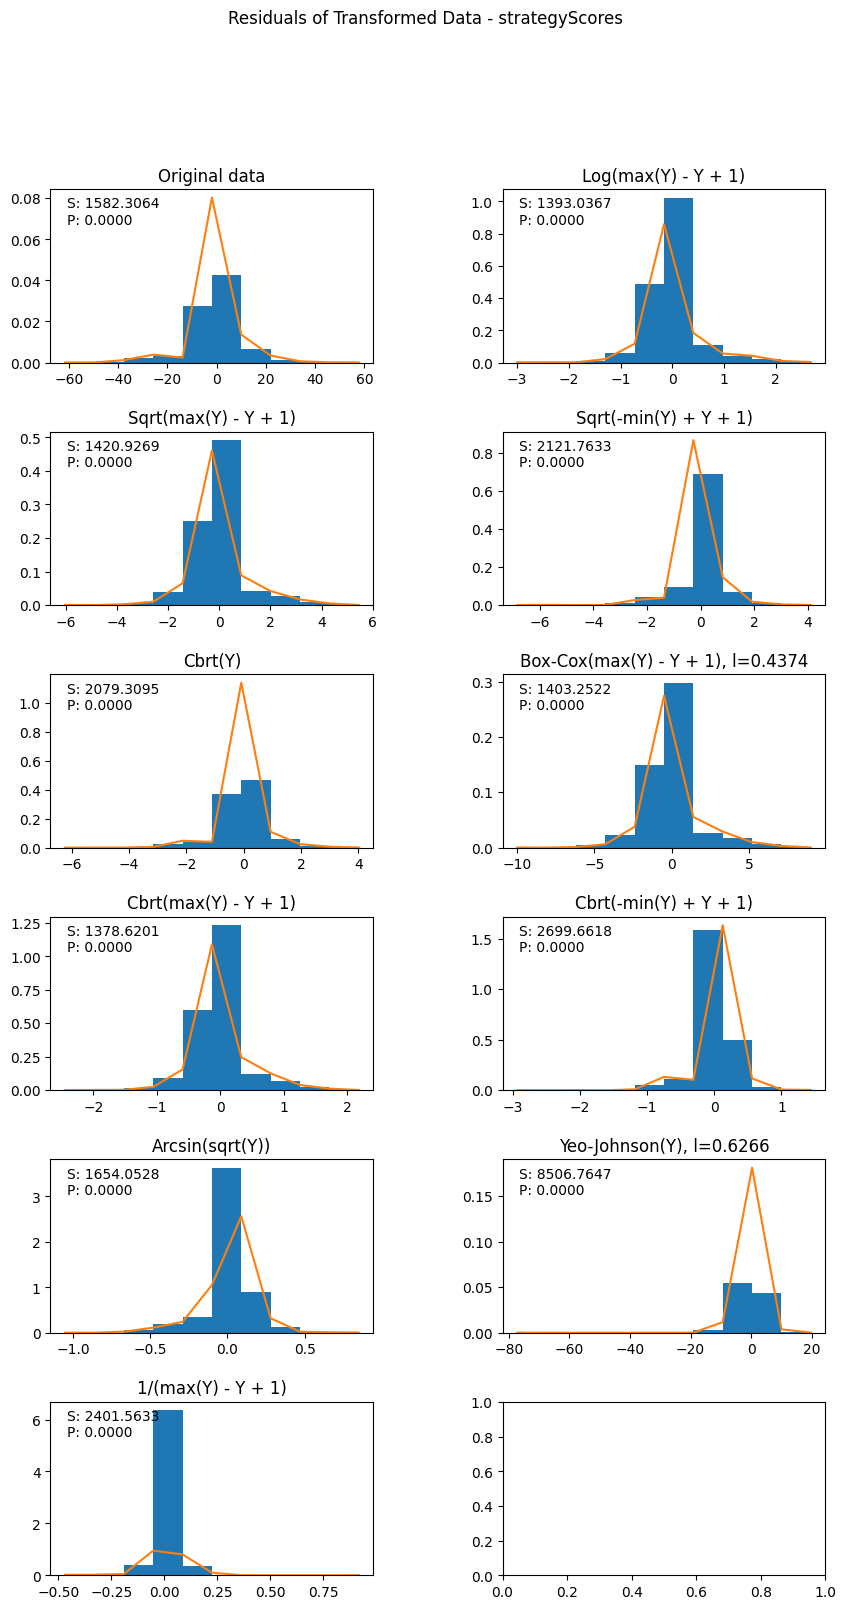

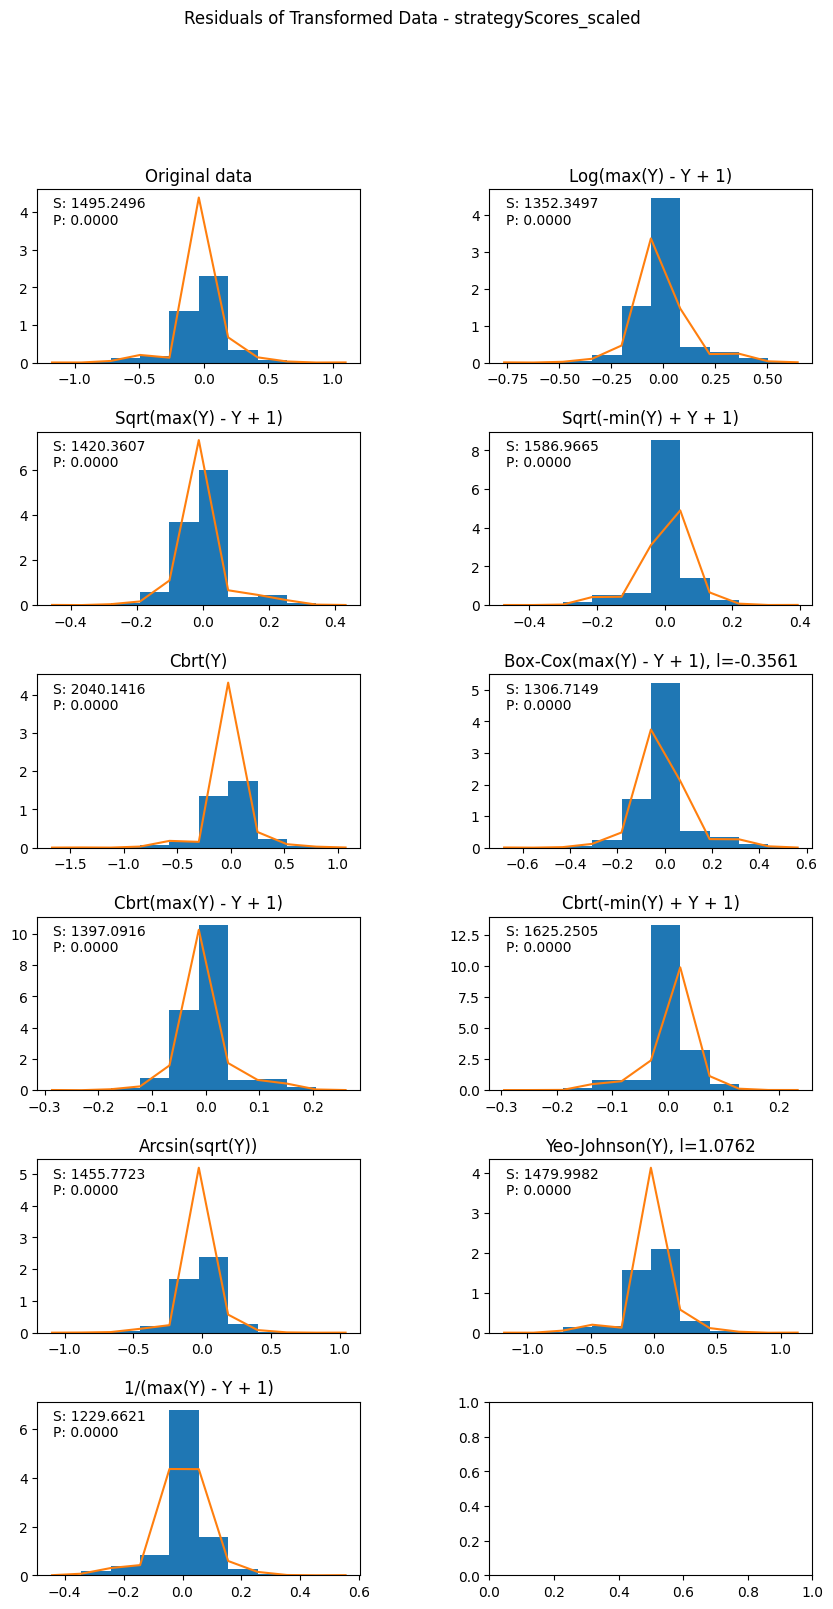

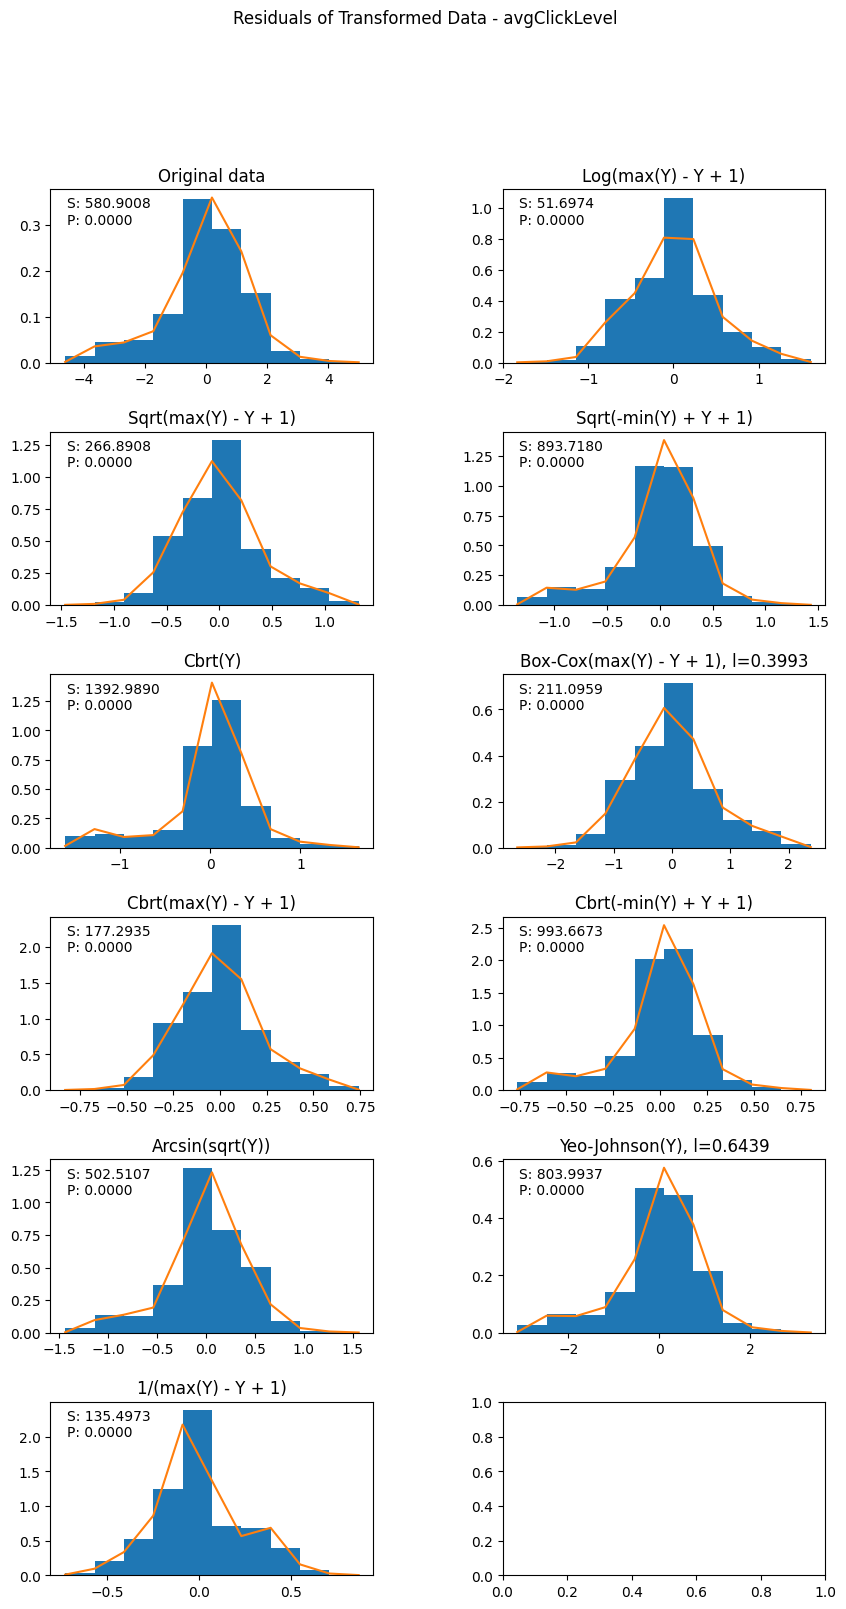

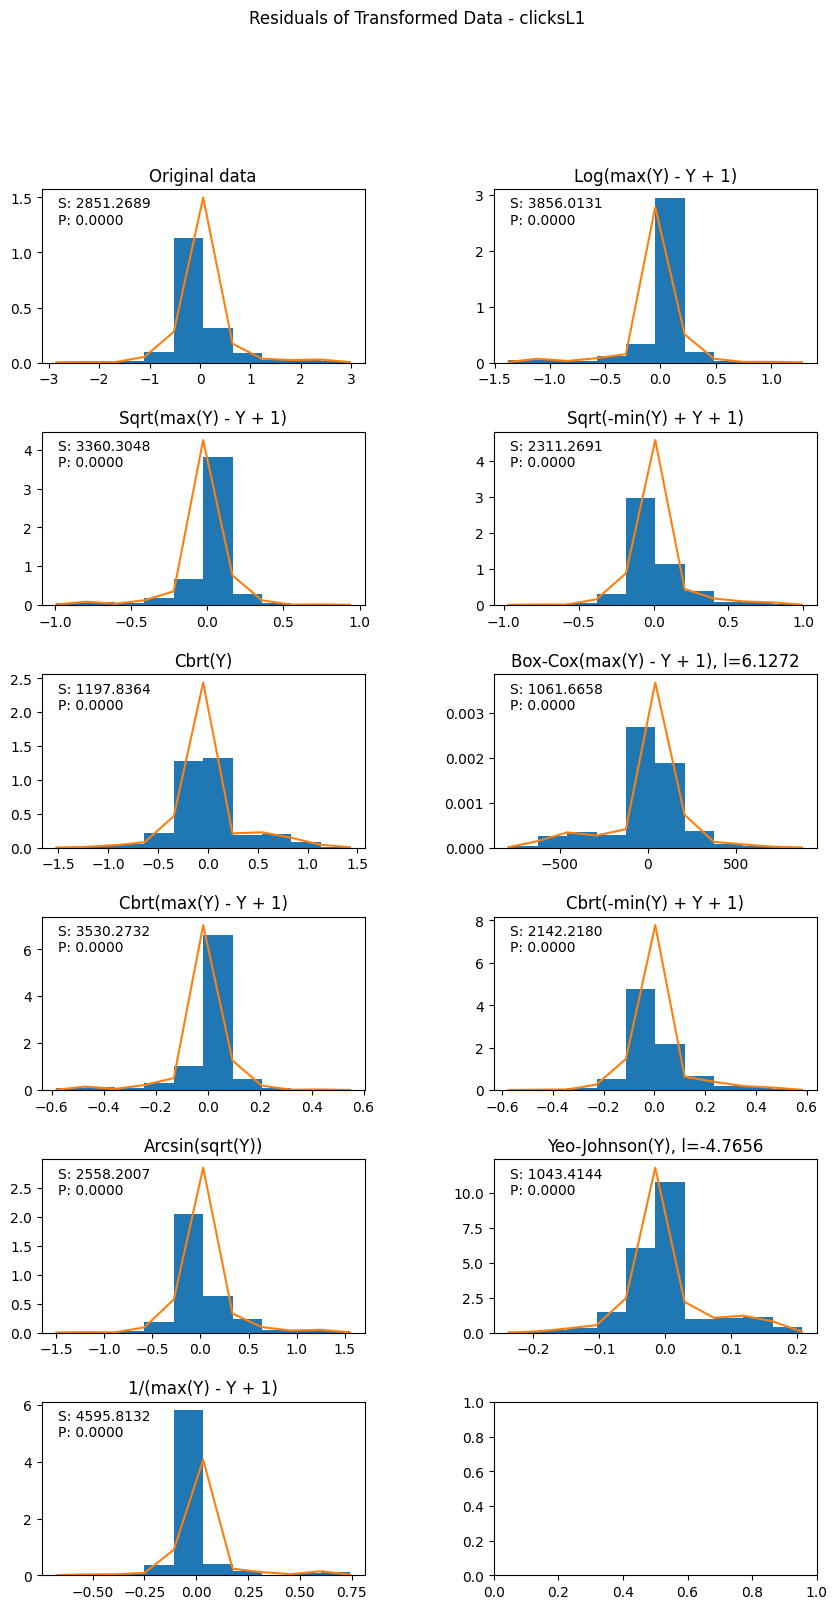

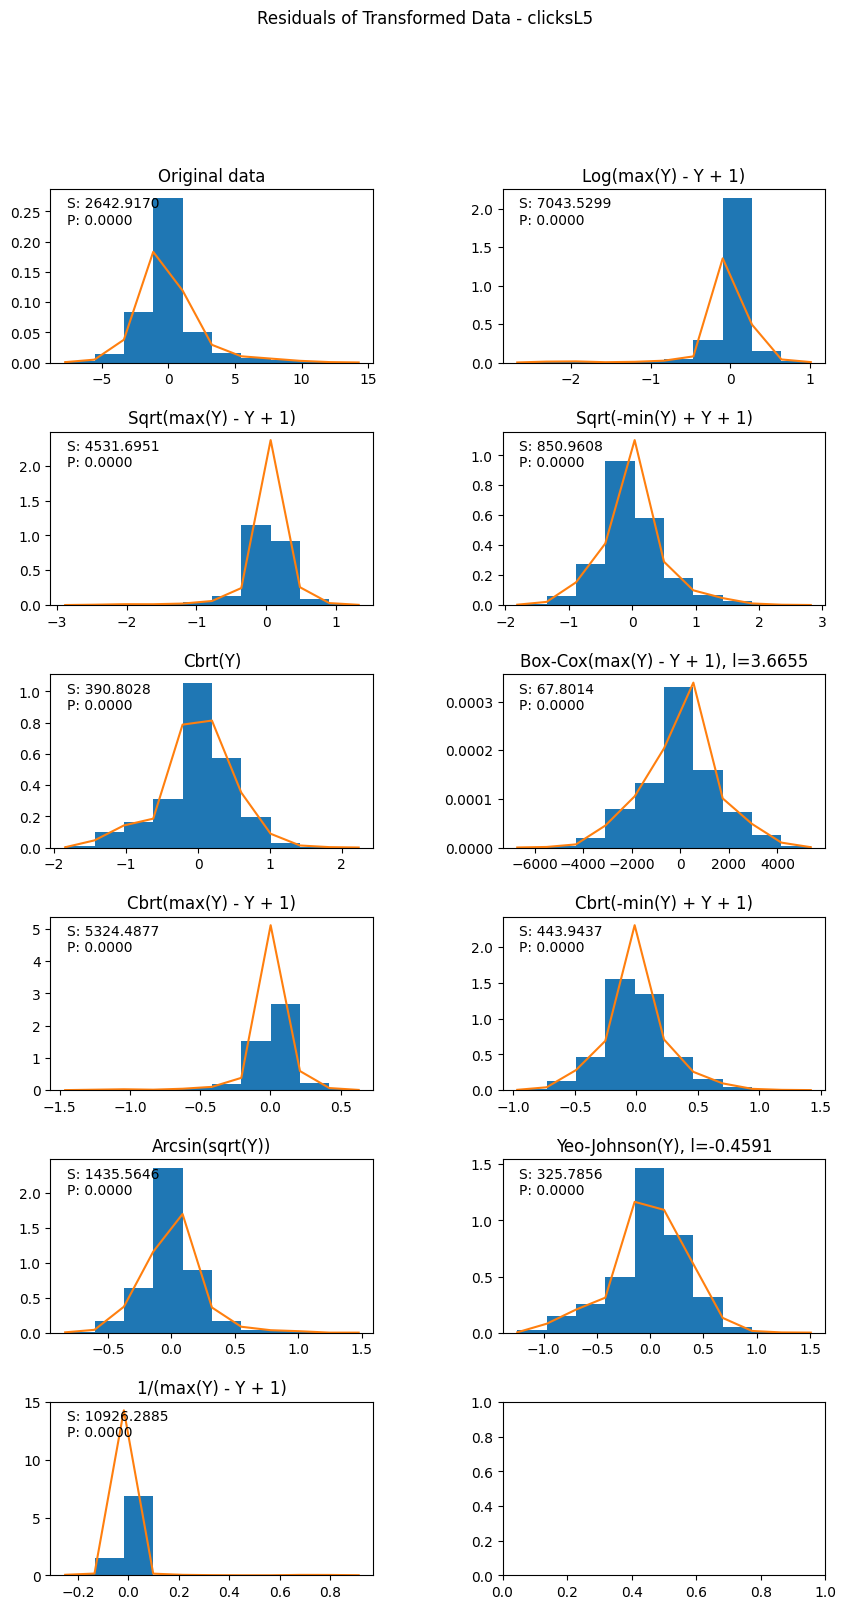

In [90]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [91]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Box-Cox(max(Y) - Y + 1), l=1.0026
expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.5479
strategyScores - Cbrt(max(Y) - Y + 1)
strategyScores_scaled - 1/(max(Y) - Y + 1)
avgClickLevel - Log(max(Y) - Y + 1)
clicksL1 - Yeo-Johnson(Y), l=-4.7656
clicksL5 - Box-Cox(max(Y) - Y + 1), l=3.6655


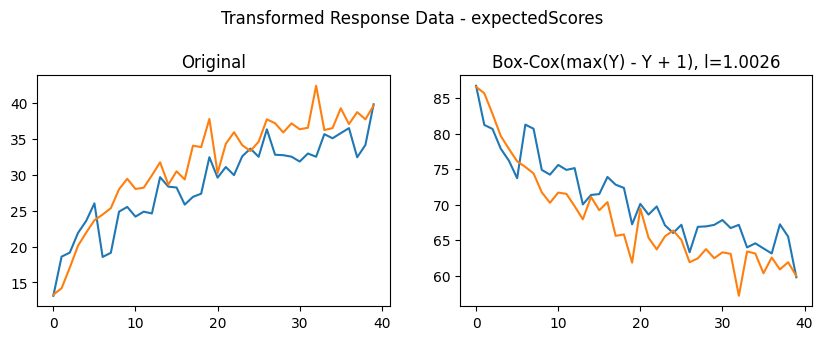

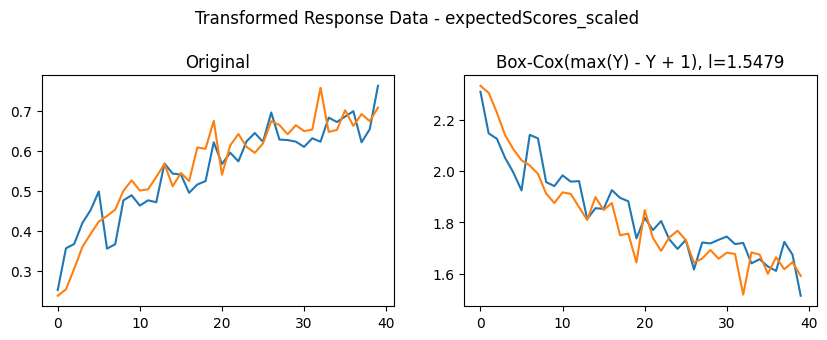

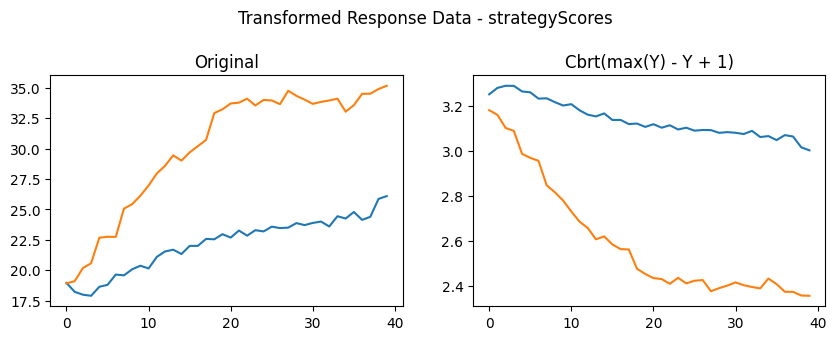

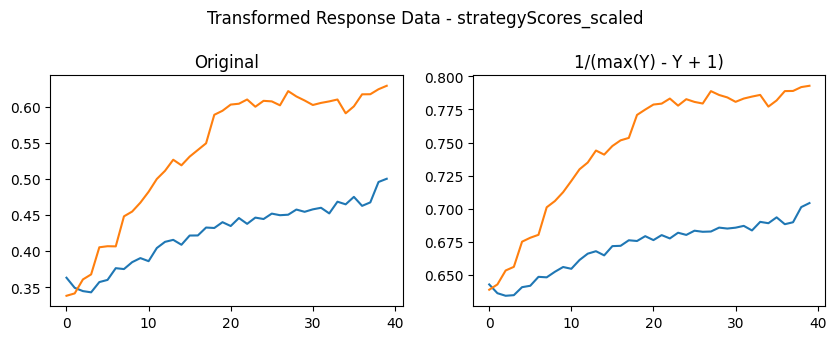

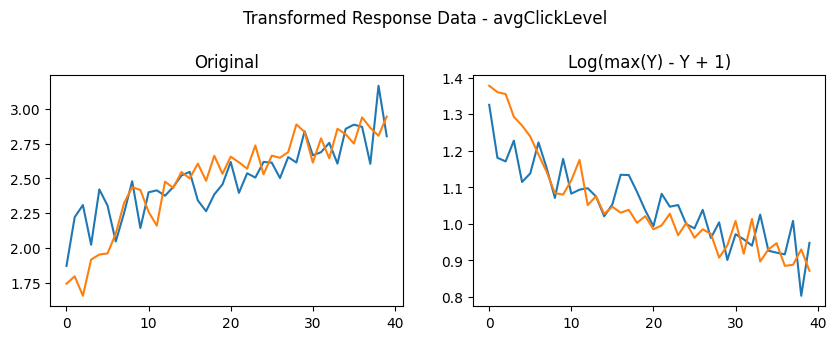

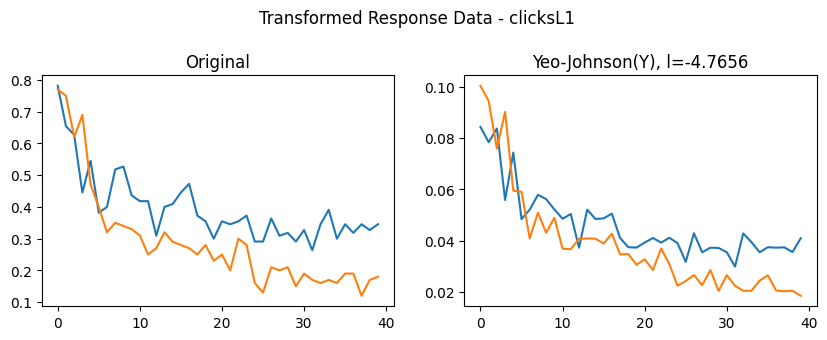

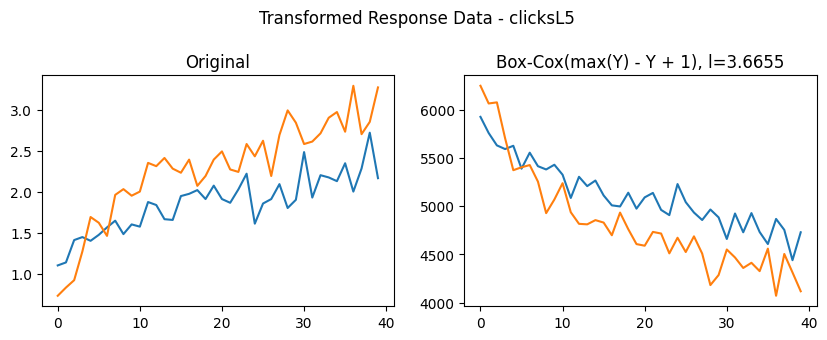

In [92]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [93]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

In [94]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
elif mis_partition_exists:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)



    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [95]:
# Showing GLM results - scarce

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


In [96]:
# Plotting candidate partitions - scarce
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1, alpha=0.5)
        plt.plot(x2, y2, alpha=0.5)

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1 + i1, color='b')
            plt.plot(x2, np.array(x2) * b2 + i2, color='orange')

        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))

    plt.show()

In [97]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [98]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [99]:
sig_bic_scores_control

[(3, 10220.277487516325),
 (4, 10217.784314863608),
 (5, 10216.164312993424),
 (6, 10215.118152474266),
 (7, 10214.204285370894),
 (8, 10213.576079923329),
 (9, 10213.532951801832),
 (10, 10213.559492537743),
 (11, 10214.283991269955),
 (12, 10215.030046084914),
 (13, 10215.442704874464),
 (14, 10215.557850856632),
 (15, 10217.136428275706),
 (16, 10217.872018206754),
 (17, 10218.537744333245),
 (18, 10218.548324426514),
 (19, 10218.780353787106),
 (20, 10217.36717105306),
 (21, 10220.257946641379),
 (22, 10220.944217774535),
 (23, 10220.967427561824),
 (24, 10222.331517031498)]

Partition candidates: 
[9.]


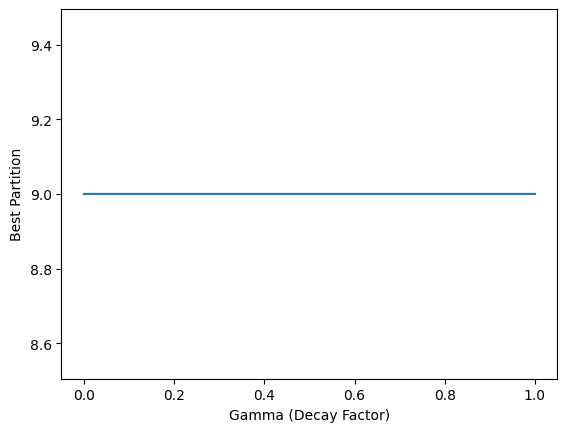

In [100]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [101]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 10213.5330

BIC Deviance: -30158.3007

AIC: 10188.3568

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                 4000
Model:                               GLM   Df Residuals:                     3996
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.74693
Method:                             IRLS   Log-Likelihood:                -5090.2
Date:                   Tue, 19 Sep 2023   Deviance:                       2984.7
Time:                           13:59:47   Pearson chi2:                 2.98e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.04771
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z| 

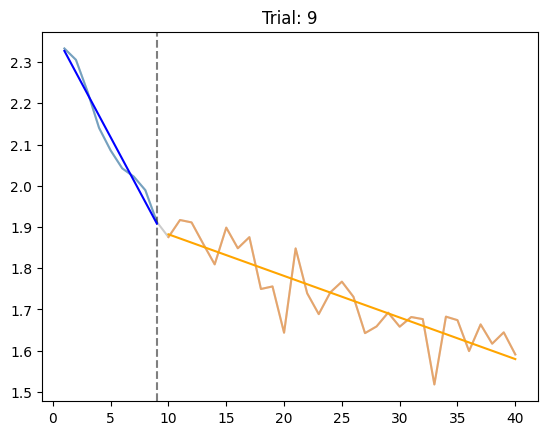

In [102]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [103]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

if not mis_partition_exists:
    scarce_partition = control_partition # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in scarce_plot_data if data[0] == scarce_partition][0]

# 1.1 - Linear Regression: Expected Score vs. Trial Number x Condition

In [119]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       1827          Method:                   REML     
No. Groups:             203           Scale:                    0.0045   
Min. group size:        9             Log-Likelihood:           2027.1935
Max. group size:        9             Converged:                Yes      
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.068    0.007 10.325 0.000  0.055  0.081
C(condition)[T.1]              -0.005    0.009 -0.510 0.610 -0.023  0.013
trialNumbers                   -0.008    0.001 -5.970 0.000 -0.010 -0.005
trialNumbers:C(condition)[T.1]  0.004    0.002  2.149 0.

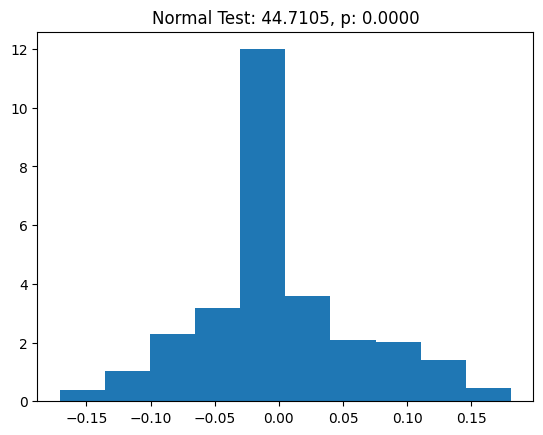

In [120]:
# Learning Phase

use_orig = False
filter_click_parts = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

learning_df[response_var] = learning_df[response_var]
# Filter out participants whose click strategies are not valid
if filter_click_parts:
    learning_df = learning_df.loc[learning_df.clickStratsValid]
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

re_formula = 'trialNumbers'

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    #control_df = learning_df.loc[learning_df.condition == 0].reset_index(drop=True)
    #scarce_df = learning_df.loc[learning_df.condition == 1].reset_index(drop=True)
    learning_df[col] = (learning_df[col] - learning_df[col].mean())#}/learning_df[col].std()
    #control_df[col] = (control_df[col] - control_df[col].mean())/control_df[col].std()
    #scarce_df[col] = (scarce_df[col] - scarce_df[col].mean())/scarce_df[col].std()
    #learning_df = pd.concat([scarce_df, control_df]).reset_index(drop=True)
    
    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, re_formula=re_formula, data=learning_df, groups=learning_df['workerId'])
    glm_2 = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()
results_2 = glm_2.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [121]:
print(results_2.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       1827          Method:                   REML     
No. Groups:             203           Scale:                    0.0052   
Min. group size:        9             Log-Likelihood:           1993.4762
Max. group size:        9             Converged:                Yes      
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.068    0.007 10.325 0.000  0.055  0.081
C(condition)[T.1]              -0.005    0.009 -0.510 0.610 -0.023  0.013
trialNumbers                   -0.008    0.001 -8.270 0.000 -0.009 -0.006
trialNumbers:C(condition)[T.1]  0.004    0.001  2.976 0.

In [122]:
def calc_bic_lmm(mdf):
    # print(mdf.nobs, mdf.df_modelwc)
    return -2 * mdf.llf + np.log(mdf.nobs) * (mdf.df_modelwc)

In [123]:
bic_rs = calc_bic_lmm(results)
bic_ri = calc_bic_lmm(results_2)
print(bic_rs)
print(bic_ri)
print(bic_ri - bic_rs)

-4001.8140481748283
-3949.4003381100474
52.413710064780844


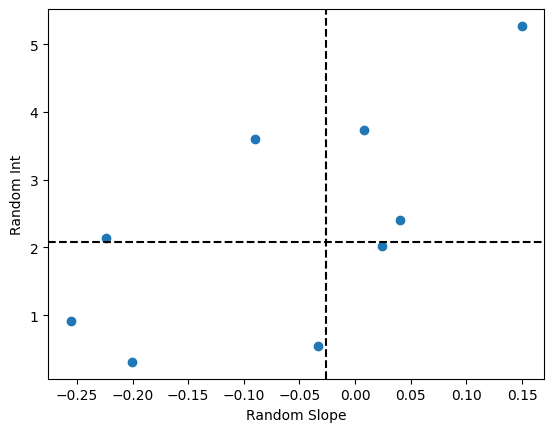

In [253]:
plt.scatter(res[:,0], res[:,1])
plt.xlabel("Random Slope")
plt.ylabel("Random Int")
plt.axvline(fs + cond * fs_int, linestyle="--",color='black')
plt.axhline(fi + cond * fi_int, linestyle='--', color='black')
plt.show()

In [258]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   1890      Method:               REML                 
No. Groups:         210       Scale:                0.3375               
Min. group size:    9         Log-Likelihood:       -1954.0341           
Max. group size:    9         Converged:            Yes                  
Mean group size:    9.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.118    0.059 35.996 0.000  2.002  2.233
C(condition)[T.1]              -0.031    0.081 -0.381 0.703 -0.190  0.128
trialNumbers                   -0.052    0.010 -5.072 0.000 -0.073 -0.032
trialNumbers:C(condition)[T.1]  0.026    0.014  1.843 0.065 -0.002  0.054
Group Var                       0.309    0.062                           
Group x trialNumbers Cov        0.019    0.008                           
trialNumbers Var                0.005    0.002                           
=========================================================================

"""

In [265]:
model.params_object

In [272]:
use_rs = True
center = True
model = results if use_rs else results_2


fs = model.params["trialNumbers"]
fs_int = model.params["trialNumbers:C(condition)[T.1]"]

try:
    rs_var = model.params["trialNumbers Var"]
except:
    rs_var = 0

fi = model.params["Intercept"]
fi_int = model.params["C(condition)[T.1]"]

try:
    ri_var = model.params["Group Var"]
except:
    ri_var = 0

try:
    rsxri_cov = model.params["Group x trialNumbers Cov"]
except:
    rsxri_cov = 0
    
# Fixed slope + interaction
fs = -0.052376
fs_int = 0.026293

# Random slope
rs_var = 0.0050375

# Fixed Intercept + interaction
fi = 2.117712
fi_int = -0.030976

# Random intercept
ri_var = 0.3086228

rsxri_cov = 0.0192782

# Generating a dataset:
N = 100
output_var_name = "expectedScores_scaled"
conditions = [0,1]
num_trials = 9
worker_id = 0
df_dict = {
    "workerId": [],
    "condition": [],
    output_var_name: [],
    "trialNumbers": []
}
for cond in conditions:
    for i in range(N):
        worker_id += 1
        trialNums = np.array(list(range(1,num_trials + 1)))
        if center:
            trialNums = trialNums - trialNums.mean()
        
        res = np.random.multivariate_normal(
            np.array([fs + cond * fs_int, fi + cond * fi_int]),
            np.array([[rs_var, rsxri_cov],
                     [rsxri_cov, ri_var]]),
            num_trials
        )
        outcomes = np.array(trialNums) * res[:,0] + res[:,1]
        df_dict["workerId"] += [worker_id] * num_trials
        df_dict["condition"] += [cond] * num_trials
        df_dict[output_var_name] += list(outcomes.flatten().astype(float))
        df_dict["trialNumbers"] += list(trialNums)
        
gen_df = pd.DataFrame.from_dict(df_dict)
gen_df

workerId  condition  expectedScores_scaled  trialNumbers
0            1          0               1.878478          -4.0
1            1          0               2.519025          -3.0
2            1          0               2.840096          -2.0
3            1          0               2.896317          -1.0
4            1          0               2.386766           0.0
...        ...        ...                    ...           ...
1795       200          1               2.111644           0.0
1796       200          1               2.823229           1.0
1797       200          1               1.423821           2.0
1798       200          1               1.490455           3.0
1799       200          1               2.364235           4.0

[1800 rows x 4 columns]

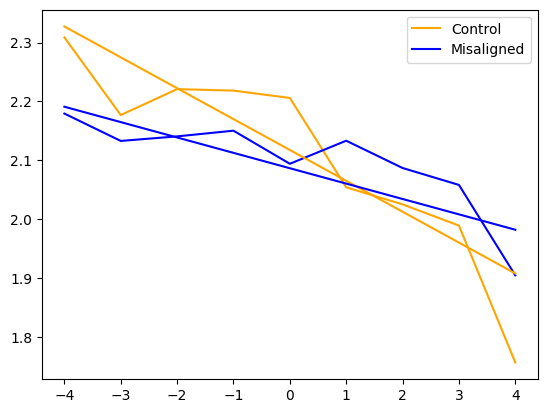

In [273]:
control_data = gen_df[gen_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[output_var_name]
exp_data = gen_df[gen_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[output_var_name]

plt.figure()
x = np.array(list(range(1,len(exp_data)+1)))
if center:
    x = x - x.mean()

plt.plot(x, control_data, label='Control',color='orange')
plt.plot(x, exp_data, label='Misaligned',color='blue')


# Slope lines
plt.plot(x, np.array(x) * (fs) + fi, color='orange')
plt.plot(x, np.array(x) * (fs + fs_int) + (fi + fi_int), color='b')
plt.legend()

plt.show()

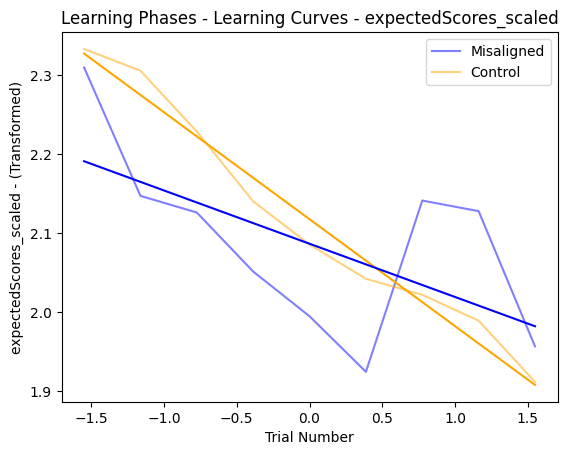

In [119]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   6510      Method:               REML                 
No. Groups:         210       Scale:                0.1467               
Min. group size:    31        Log-Likelihood:       -3391.0809           
Max. group size:    31        Converged:            Yes                  
Mean group size:    31.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.458    0.047  9.656 0.000  0.365  0.551
C(condition)[T.1]              -0.042    0.065 -0.646 0.518 -0.171  0.086
trialNumbers                    0.006    0.001  8.386 0.000  0.005  0.008
trialNumbers:C(condition)[T.1]  0.001    0.001  0.848 0.

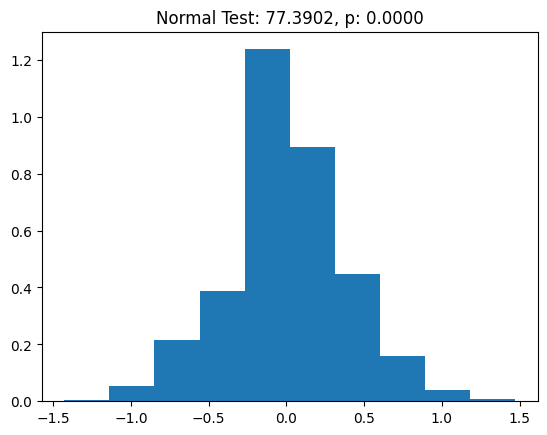

In [357]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)



mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

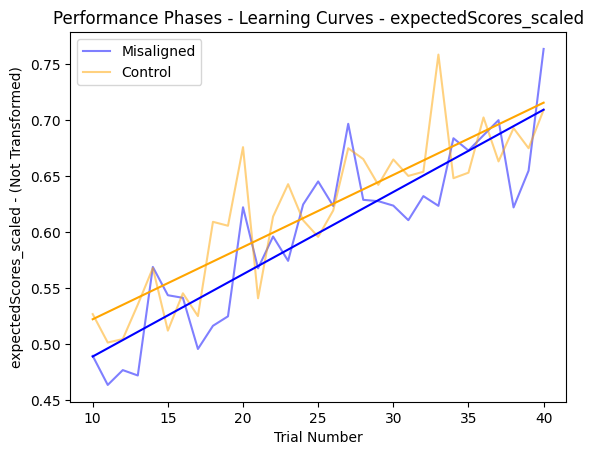

In [358]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.2 - Independent Samples T-test

In [136]:
# Select the response variable for this analysis

response_var = "numClicks"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

AssertionError: numClicks is not a valid response variable

In [137]:
# Scores of first trial

use_transformed = False

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_learning_data.loc[control_learning_data.trialNumbers == 1]
    scarce_averages = scarce_learning_data.loc[scarce_learning_data.trialNumbers == 1]
else:
    # Using the original data divided into phases
    control_averages = control_learning_data_orig.loc[control_learning_data_orig.trialNumbers == 1]
    scarce_averages = scarce_learning_data_orig.loc[scarce_learning_data_orig.trialNumbers == 1]
    

L: 1, Control outliers: 0
L: 1, Misaligned outliers: 0
L: 2, Control outliers: 0
L: 2, Misaligned outliers: 0
L: 3, Control outliers: 0
L: 3, Misaligned outliers: 0
L: 4, Control outliers: 0
L: 4, Misaligned outliers: 0
L: 5, Control outliers: 0
L: 5, Misaligned outliers: 0


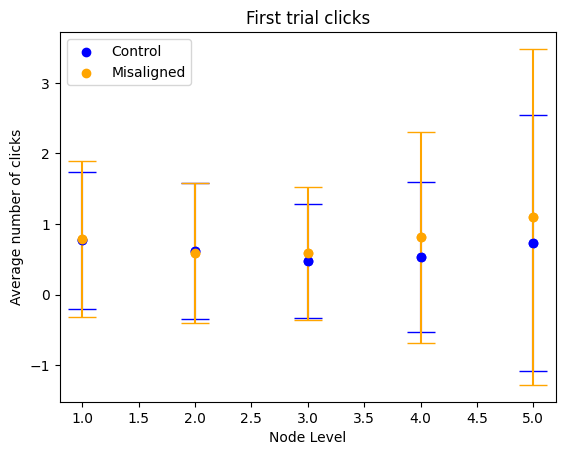

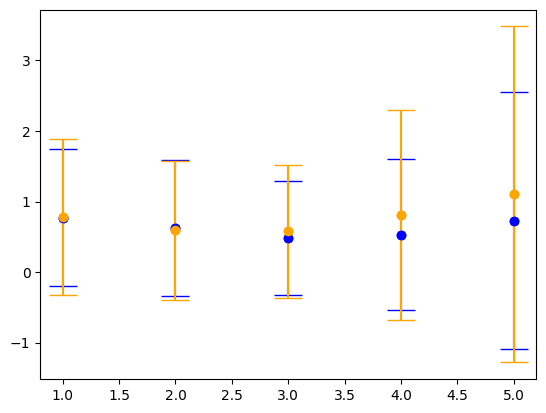

In [142]:


levels = range(1,6)

for l in levels:
    col = f"clicksL{l}"
    control_col = control_averages[col]
    scarce_col = scarce_averages[col]
    
    plt.figure(1)
    plt.title("First trial clicks")
    plt.xlabel("Node Level")
    plt.ylabel("Average number of clicks")
    if l == 1:
        plt.scatter(l, control_col.mean(), color="blue", label="Control")
        plt.errorbar(l, control_col.mean(), yerr=control_col.std(), fmt="o", color="blue",capsize=10)
    
        plt.scatter(l, scarce_col.mean(), color="orange", label="Misaligned")
        plt.errorbar(l, scarce_col.mean(), yerr=scarce_col.std(), fmt="o", color="orange", capsize=10)
    else:
        plt.scatter(l, control_col.mean(), color="blue")
        plt.errorbar(l, control_col.mean(), yerr=control_col.std(), fmt="o", color="blue",capsize=10)
    
        plt.scatter(l, scarce_col.mean(), color="orange")
        plt.errorbar(l, scarce_col.mean(), yerr=scarce_col.std(), fmt="o", color="orange", capsize=10)
    
    plt.legend()
    # Removing outliers
    plt.figure(2)
    control_col_wo = control_col.loc[(control_col < control_col.mean() + 3 * control_col.std()) | (control_col > control_col.mean() - 3 * control_col.std())]
    print(f"L: {l}, Control outliers: {len(control_col) - len(control_col_wo)}")
    
    plt.scatter(l, control_col_wo.mean(), color="blue")
    plt.errorbar(l, control_col_wo.mean(), yerr=control_col_wo.std(), fmt="o", color="blue",capsize=10)
    
    scarce_col_wo = scarce_col.loc[(scarce_col < scarce_col.mean() + 3 * scarce_col.std()) | (scarce_col > scarce_col.mean() - 3 * scarce_col.std())]
    print(f"L: {l}, Misaligned outliers: {len(scarce_col) - len(scarce_col_wo)}")
    
    plt.scatter(l, scarce_col_wo.mean(), color="orange")
    plt.errorbar(l, scarce_col_wo.mean(), yerr=scarce_col_wo.std(), fmt="o", color="orange",capsize=10)

plt.show()

In [360]:
use_transformed = True

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data.groupby('workerId').mean(numeric_only=True)
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    

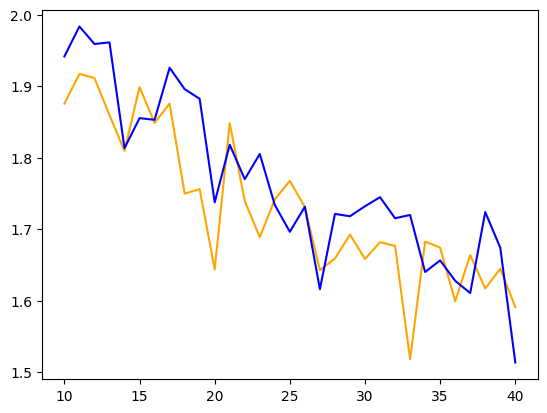

In [361]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='b')
plt.show()

3.31 4.726232403011168
4.1909090909090905 6.050999545219523


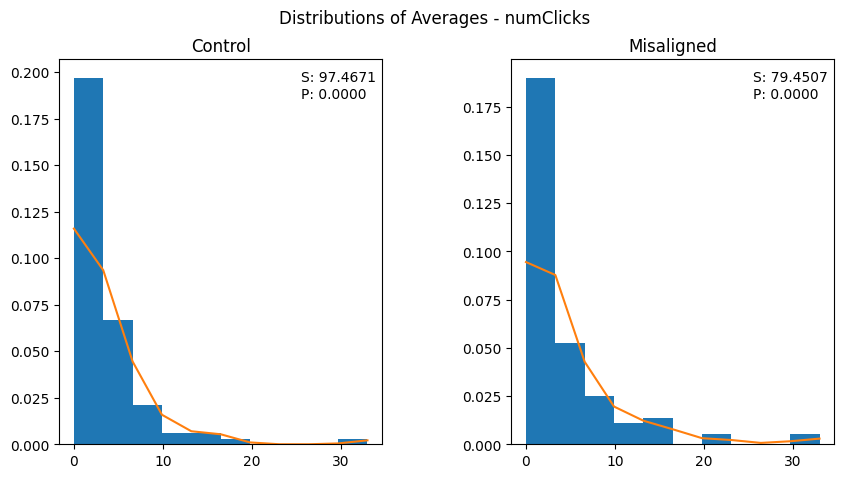

In [138]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [139]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: numClicks
Two-Sided:
	Statistic: 1.168
	P-value: 0.24433066188099434
Scarce < Control:
	Statistic: 1.168
	P-value: 0.8778346690595028
Scarce > Control:
	Statistic: 1.168
	P-value: 0.12216533094049717


In [140]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 5750.000
	P-value: 0.5635207680987642
Misaligned < Control:
	Statistic: 5750.000
	P-value: 0.7190207775576702
Misaligned > Control:
	Statistic: 5750.000
	P-value: 0.2817603840493821


# 2.1 - Linear Regression: AvgClickDepth vs. Trial Number x Condition

In [120]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       1827        Method:                 REML         
No. Groups:             203         Scale:                  1.7419       
Min. group size:        9           Log-Likelihood:         -3328.5029   
Max. group size:        9           Converged:              Yes          
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.988    0.133 14.950 0.000  1.727  2.248
C(condition)[T.1]               0.210    0.187  1.123 0.261 -0.156  0.575
trialNumbers                    0.228    0.044  5.174 0.000  0.141  0.314
trialNumbers:C(condition)[T.1] -0.144    0.062 -2.323 0.

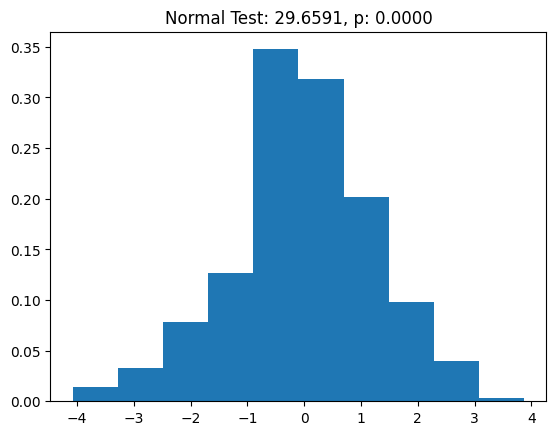

In [121]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) / learning_df[col].std()

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

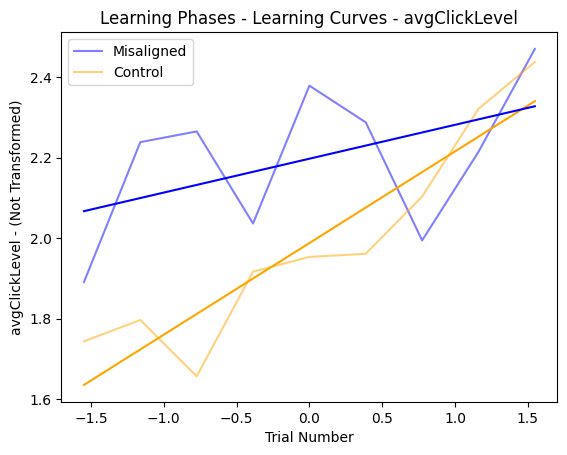

In [122]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       6293        Method:                 REML         
No. Groups:             203         Scale:                  0.2348       
Min. group size:        31          Log-Likelihood:         -4741.7344   
Max. group size:        31          Converged:              Yes          
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.162    0.056 20.692 0.000  1.052  1.272
C(condition)[T.1]               0.061    0.079  0.773 0.440 -0.094  0.216
trialNumbers                   -0.007    0.001 -7.064 0.000 -0.009 -0.005
trialNumbers:C(condition)[T.1] -0.001    0.001 -0.875 0.

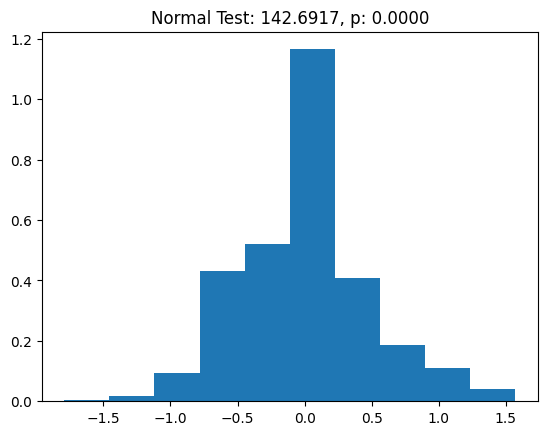

In [368]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

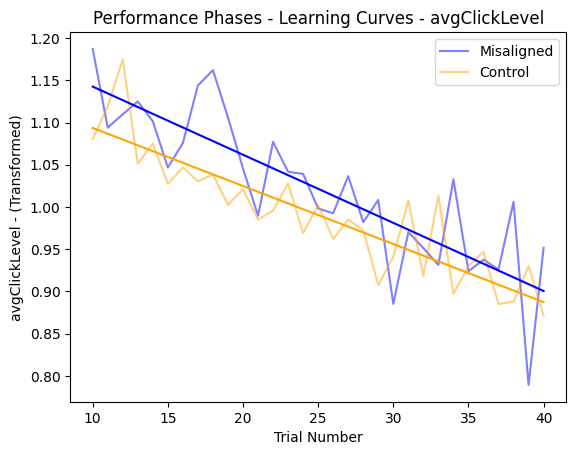

In [369]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.2 - Linear Regression: ClicksL5 vs. Trial Number x Condition

In [123]:
# Select the response variable for this analysis

response_var = "clicksL5"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         clicksL5    
No. Observations:         1827            Method:                     REML        
No. Groups:               203             Scale:                      1925337.7132
Min. group size:          9               Log-Likelihood:             -16025.4325 
Max. group size:          9               Converged:                  Yes         
Mean group size:          9.0                                                     
----------------------------------------------------------------------------------
                                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                         5608.440  148.980 37.645 0.000 5316.444 5900.437
C(condition)[T.1]                   -4.746  209.150 -0.023 0.982 -414.673  405.181
trialNumbers               

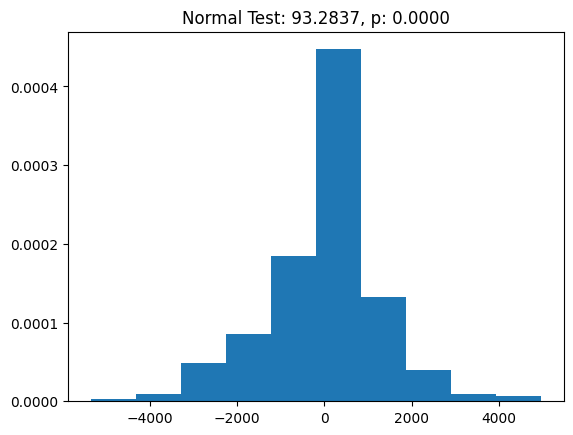

In [126]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) / learning_df[col].std()

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

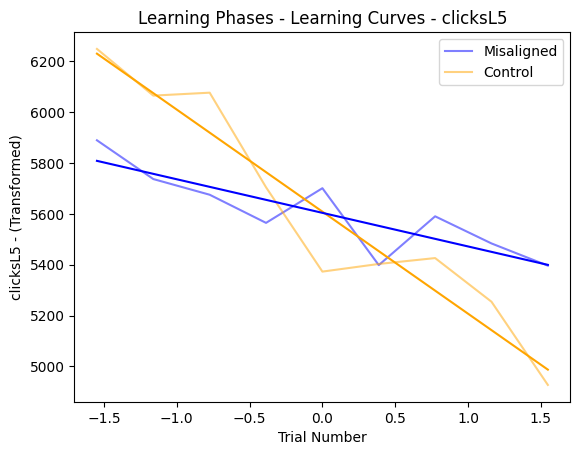

In [128]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         clicksL5    
No. Observations:         6293            Method:                     REML        
No. Groups:               203             Scale:                      2357169.7684
Min. group size:          31              Log-Likelihood:             -55450.5920 
Max. group size:          31              Converged:                  Yes         
Mean group size:          31.0                                                    
----------------------------------------------------------------------------------
                                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                         5254.498  187.925 27.961 0.000 4886.172 5622.824
C(condition)[T.1]                  312.208  263.824  1.183 0.237 -204.877  829.293
trialNumbers               

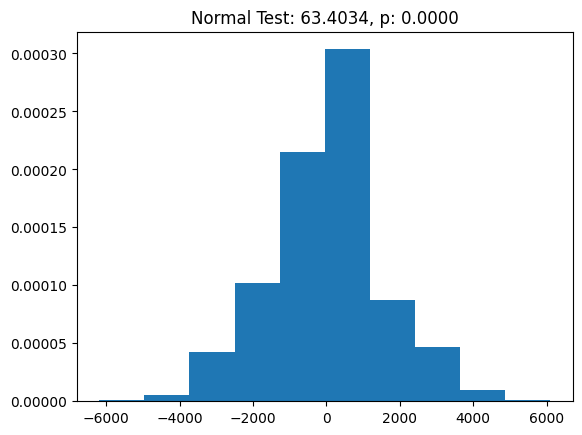

In [373]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

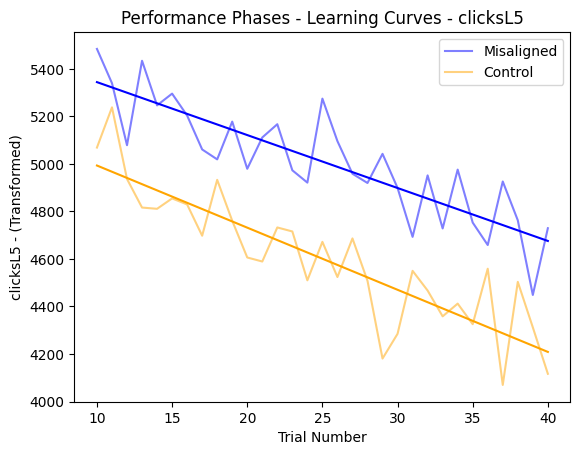

In [374]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.3 - Linear Regression: ClicksL1 vs. Trial Number x Condition

In [162]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       1827          Method:                   REML     
No. Groups:             203           Scale:                    0.0052   
Min. group size:        9             Log-Likelihood:           1993.4762
Max. group size:        9             Converged:                Yes      
Mean group size:        9.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.107    0.008 13.202 0.000  0.091  0.122
C(condition)[T.1]              -0.024    0.011 -2.128 0.033 -0.046 -0.002
trialNumbers                   -0.008    0.001 -8.270 0.000 -0.009 -0.006
trialNumbers:C(condition)[T.1]  0.004    0.001  2.976 0.

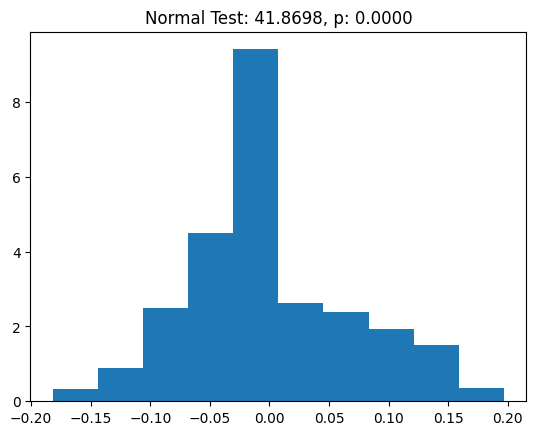

In [167]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = []
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

# learning_df["clicksL1"] = learning_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

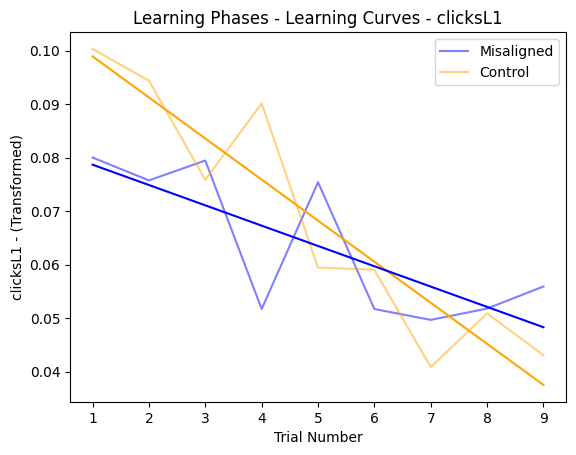

In [168]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       6293         Method:                  REML       
No. Groups:             203          Scale:                   23.8837    
Min. group size:        31           Log-Likelihood:          -19305.2262
Max. group size:        31           Converged:               Yes        
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       5.041    0.639  7.891 0.000  3.789  6.293
C(condition)[T.1]               0.045    0.897  0.051 0.960 -1.712  1.803
trialNumbers                   -0.083    0.010 -8.428 0.000 -0.102 -0.063
trialNumbers:C(condition)[T.1]  0.032    0.014  2.315 0.

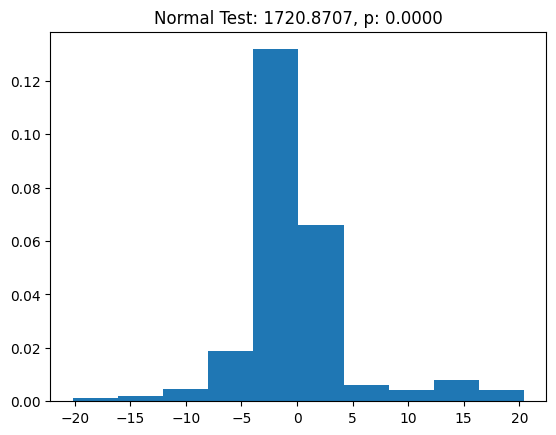

In [378]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df["clicksL1"] = performance_df["clicksL1"] * 100

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

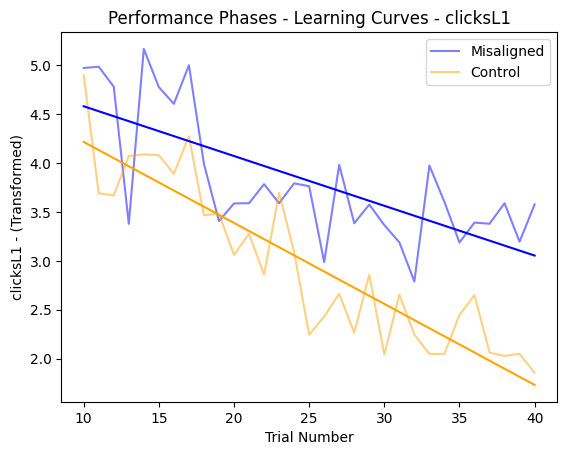

In [379]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.4 - Linear Regression: Strategy Score vs. Trial Number x Condition

In [135]:
# Select the response variable for this analysis

response_var = "strategyScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   1827      Method:               REML                 
No. Groups:         203       Scale:                0.0279               
Min. group size:    9         Log-Likelihood:       287.7868             
Max. group size:    9         Converged:            Yes                  
Mean group size:    9.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.392    0.036 11.002 0.000  0.322  0.462
C(condition)[T.1]              -0.039    0.050 -0.774 0.439 -0.137  0.059
trialNumbers                    0.039    0.006  7.088 0.000  0.029  0.050
trialNumbers:C(condition)[T.1] -0.031    0.008 -4.025 0.

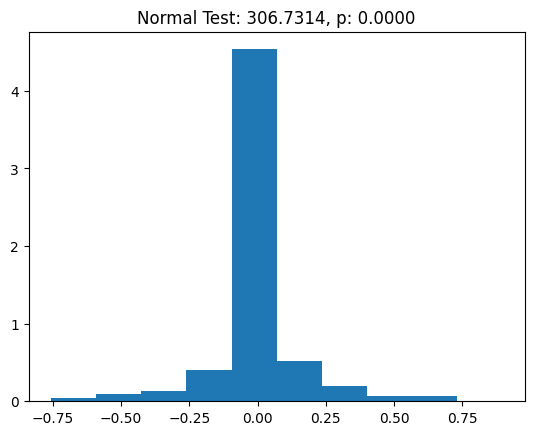

In [136]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

standardize_cols = ["trialNumbers"]
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) / learning_df[col].std()

    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

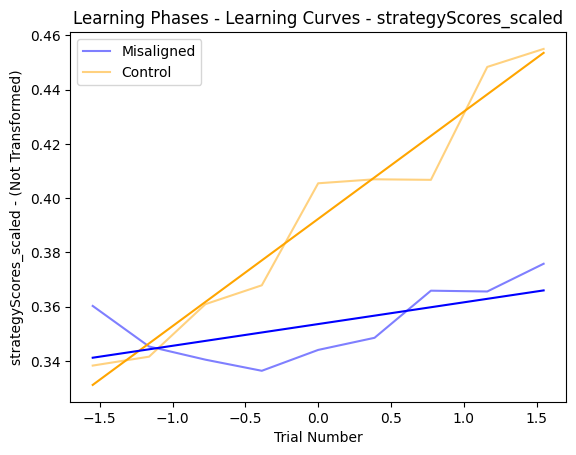

In [137]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       6293         Method:                  REML       
No. Groups:             203          Scale:                   23.8837    
Min. group size:        31           Log-Likelihood:          -19305.2262
Max. group size:        31           Converged:               Yes        
Mean group size:        31.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       5.041    0.639  7.891 0.000  3.789  6.293
C(condition)[T.1]               0.045    0.897  0.051 0.960 -1.712  1.803
trialNumbers                   -0.083    0.010 -8.428 0.000 -0.102 -0.063
trialNumbers:C(condition)[T.1]  0.032    0.014  2.315 0.

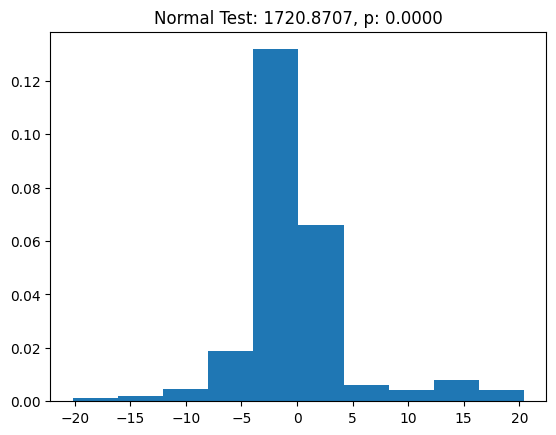

In [134]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df[response_var] = performance_df[response_var] * 100

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

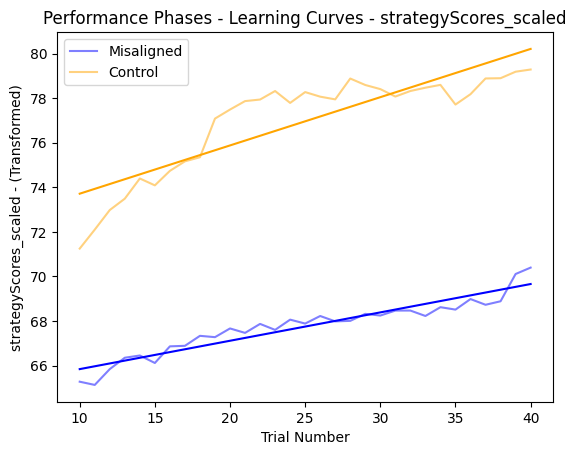

In [384]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# Appendix

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

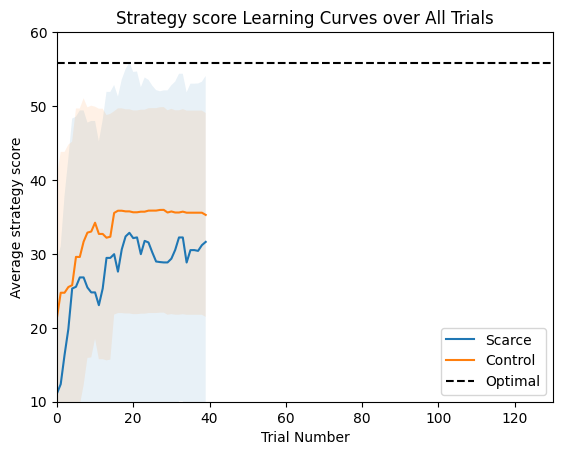

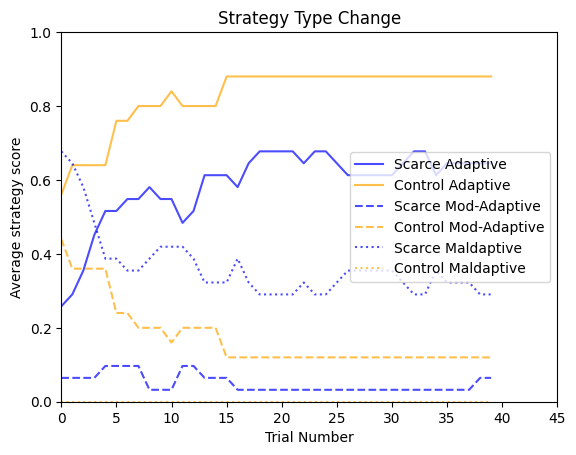

In [151]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0